# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import os
from decimal import Decimal
import pickle
from pathlib import Path

from sklearn import linear_model
import statsmodels.api as sm

import copy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.io import write_image #para salvar p excel

from openpyxl import Workbook
from openpyxl.drawing.image import Image

# SETUP

In [2]:
dir_tree_util_path = os.path.join("utils", "dir_tree.py")
exec(open(dir_tree_util_path).read())

# INPUTS

In [3]:
file_PIB = 'PIB-Ipea-trimestral.parquet'

In [4]:
periodicidade_path = 'TRIMESTRAL'

In [5]:
periodicidade = 'Q'
periodos = [['2010Q2','2023Q4'], ['2016Q1','2023Q4']] # formato Y/M, inclusive

# PATHS

In [6]:
# Paths
path_dados_trafego = PROJECT_DIRS[f"DADOS_TRAFEGO_AJUSTADOS_{periodicidade_path}_DIR"]
path_comercial = path_dados_trafego / f'df_VEQS_COMERCIAL_{periodicidade_path.lower()}_saz_adjusted.parquet'
path_passeio = path_dados_trafego / f'df_VEQS_PASSEIO_{periodicidade_path.lower()}_saz_adjusted.parquet'
path_dados_PIB = PROJECT_DIRS["DADOS_PIB_DIR"]

path_outputs = PROJECT_DIRS[f"DADOS_REGRESSAO_{periodicidade_path}_DIR"]
# path_output = PROJECT_DIRS["DADOS_REGRESSAO_DIR"] / PROJECT_DIRS[f"DADOS_REGRESSAO_{periodicidade_path}_DIR"]

path_temp_figs = PROJECT_DIRS["DADOS_DERIVADOS_DIR"] / 'temp'

In [7]:
path_outputs

PosixPath('/home/andcm/work/Projetos/infra-data/dados/derivados/regressoes/trimestral')

# CARREGANDO OS DADOS p/MEMORIA

In [8]:
df_veqs_comercial = pd.read_parquet(path_comercial)
df_veqs_passeio = pd.read_parquet(path_passeio)


dict_veqs_trafego = {'VEQS_COMERCIAL':df_veqs_comercial,
           'VEQS_PASSEIO':df_veqs_passeio}

In [9]:
dict_veqs_trafego['VEQS_COMERCIAL'].tail()

AUTOPISTA FERNÃO DIAS  AUTOPISTA FLUMINENSE  AUTOPISTA LITORAL SUL  \
trimestre                                                                       
2023Q2              2.849596e+07          6.049600e+06           2.344030e+07   
2023Q3              2.886496e+07          6.063527e+06           2.443476e+07   
2023Q4              2.975438e+07          6.317419e+06           2.461045e+07   
2024Q1                       NaN          4.963453e+06           2.203759e+07   
2024Q2                       NaN                   NaN                    NaN   

           AUTOPISTA PLANALTO SUL  AUTOPISTA REGIS BITTENCOURT      CONCEBRA  \
trimestre                                                                      
2023Q2               5.965381e+06                 3.252595e+07  1.611815e+07   
2023Q3               5.706543e+06                 3.275433e+07  1.658815e+07   
2023Q4               6.340225e+06                 3.312828e+07  1.639307e+07   
2024Q1               6.495440e+06                          NaN  1.668140e+07   
2024Q2                        NaN                          NaN           NaN   

           CONCEPA        CONCER           CRO  CRT  ...      ECOPONTE  \
trimestre                                            ...                 
2023Q2         NaN  2.835717e+06  2.545885e+07  NaN  ...  1.076378e+06   
2023Q3         NaN  2.843669e+06  2.586970e+07  NaN  ...  1.085367e+06   
2023Q4         NaN  2.915308e+06  2.672731e+07  NaN  ...  1.092828e+06   
2024Q1         NaN  2.685246e+06  2.078548e+07  NaN  ...  9.631779e+05   
2024Q2         NaN           NaN           NaN  NaN  ...           NaN   

                 ECOSUL  ECOVIAS DO CERRADO         MSVIA  NOVADUTRA  \
trimestre                                                              
2023Q2     4.708813e+06        6.883026e+06  1.103609e+07        NaN   
2023Q3     5.186370e+06        7.452304e+06  1.150635e+07        NaN   
2023Q4     5.536026e+06        7.661127e+06  1.212538e+07        NaN   
2024Q1     4.908351e+06        6.657111e+06  1.135945e+07        NaN   
2024Q2              NaN                 NaN           NaN        NaN   

           RODOVIA DO AÇO  TRANSBRASILIANA       VIA 040     VIA BAHIA  \
trimestre                                                                
2023Q2       3.273804e+06     4.073577e+06  1.470192e+07  1.661487e+07   
2023Q3       3.257353e+06     4.182333e+06  1.459565e+07  1.626668e+07   
2023Q4       3.196716e+06     4.022169e+06  1.492082e+07  1.508796e+07   
2024Q1       3.060220e+06     1.350965e+06  1.287811e+07  1.640466e+07   
2024Q2                NaN              NaN           NaN           NaN   

                VIA SUL  
trimestre                
2023Q2     1.342538e+07  
2023Q3     1.370223e+07  
2023Q4     1.391393e+07  
2024Q1     7.693904e+06  
2024Q2              NaN  

[5 rows x 22 columns]

In [10]:
# Dados de PIB
df_pib_raw = pd.read_parquet(path_dados_PIB / file_PIB)

# Tratando os dados

## Funções

In [11]:
def remove_outliers(df_raw, col_dados, thresh=2.0):
    df = pd.DataFrame(index=df_raw.index)
    df['Dados_brutos'] = df_raw.dropna()
    df['mean'] = df['Dados_brutos'].mean()
    df['std'] = df['Dados_brutos'].std()
    df['dist_std_mean'] = (df['Dados_brutos'] - df['mean']) / df['std']
    
    # condition = abs(abs(df['dist_std_mean']) - thresh) > 1e-8
    condition = (abs(df['dist_std_mean']) - thresh) < 1e-8
    df = df.loc[condition]
    
    df[col_dados] = df['Dados_brutos']
    
    return df[col_dados]

## PIB

In [12]:
df_pib = df_pib_raw.copy()

In [13]:
# filtrando PIB para o periodo
df_pib = df_pib.loc[periodos[0][0] : periodos[0][1]]

In [14]:
len(df_pib)

55

In [15]:
# Removendo outliers do PIB
df_pib = remove_outliers(df_pib, 'PIB_real_pct', thresh=2.0)

In [16]:
len(df_pib)

53

## Trafego

In [17]:
dict_veqs = copy.deepcopy(dict_veqs_trafego)

In [18]:
# trocando zeros para NaN
for veq, df in dict_veqs.items():
    for col in df:
        df[col] = df[col].apply(lambda x: x if (abs(x) > 1e-8) else None)

In [19]:
# Convertendo os dados para variação relativa em pct (=PIB)
for veq, df in dict_veqs.items():
    for col in df:
        df[col] = df[col].dropna().pct_change().replace([np.inf, -np.inf], None) * 100

In [20]:
# retirando outliers
for veq, df in dict_veqs.items():
    for col in df:
        len1 = len(df[col].dropna())
        df[col] = remove_outliers(df[col], col, thresh=2.0)
        len2 = len(df[col].dropna())
        print(len2-len1, veq, col) 
        # OBS: outliers ficam como NaN

-5 VEQS_COMERCIAL AUTOPISTA FERNÃO DIAS
-2 VEQS_COMERCIAL AUTOPISTA FLUMINENSE
-4 VEQS_COMERCIAL AUTOPISTA LITORAL SUL
-3 VEQS_COMERCIAL AUTOPISTA PLANALTO SUL
-2 VEQS_COMERCIAL AUTOPISTA REGIS BITTENCOURT
-1 VEQS_COMERCIAL CONCEBRA
-1 VEQS_COMERCIAL CONCEPA
-3 VEQS_COMERCIAL CONCER
-3 VEQS_COMERCIAL CRO
-2 VEQS_COMERCIAL CRT
-3 VEQS_COMERCIAL ECO050
-2 VEQS_COMERCIAL ECO101 CONCESSIONARIA DE RODOVIAS S/A
-2 VEQS_COMERCIAL ECOPONTE
-4 VEQS_COMERCIAL ECOSUL
0 VEQS_COMERCIAL ECOVIAS DO CERRADO
-1 VEQS_COMERCIAL MSVIA
-3 VEQS_COMERCIAL NOVADUTRA
-4 VEQS_COMERCIAL RODOVIA DO AÇO
-1 VEQS_COMERCIAL TRANSBRASILIANA
-3 VEQS_COMERCIAL VIA 040
-2 VEQS_COMERCIAL VIA BAHIA
-1 VEQS_COMERCIAL VIA SUL
-3 VEQS_PASSEIO AUTOPISTA FERNÃO DIAS
-3 VEQS_PASSEIO AUTOPISTA FLUMINENSE
-5 VEQS_PASSEIO AUTOPISTA LITORAL SUL
-3 VEQS_PASSEIO AUTOPISTA PLANALTO SUL
-4 VEQS_PASSEIO AUTOPISTA REGIS BITTENCOURT
-3 VEQS_PASSEIO CONCEBRA
-2 VEQS_PASSEIO CONCEPA
-2 VEQS_PASSEIO CONCER
-3 VEQS_PASSEIO CRO
-3 VEQS_PASSEIO 

# FUNCÕES

In [28]:
def make_base_train(df_y, df_X, periodo:list, periodicidade, drop_inverted, drop_X_negatives):  
    
    if drop_X_negatives:
        df_X = df_X.loc[df_X > 1e-8]
    
    df_train = pd.merge(df_y, df_X, how='inner', left_index=True, right_index=True)
    df_train = df_train.dropna(how='any')
    df_train = df_train.loc[periodo[0]:periodo[1]]  
    
    # print(df_train.index[0])
    # print(pd.to_datetime(periodo[0]).to_period('Q'))
    # print(df_train.index[0] > pd.to_datetime(periodo[0]).to_period('Q'))
    
    if df_train.index[0] > pd.to_datetime(periodo[0]).to_period(periodicidade):
        return None
    
    if drop_inverted:
        df_train['rows_drop'] = df_train.iloc[:,0] * df_train.iloc[:,1]
        df_train = df_train.loc[df_train['rows_drop'] > 0]
        df_train = df_train.drop(columns=['rows_drop'])
    
    return df_train

In [29]:
def regressao(df_train, conc, col_X, fit_intercept):
    y_train = df_train[conc]
    X_train = df_train[col_X]
    if fit_intercept:
        X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model

In [30]:
# def regressao(y_train, X_train, fit_intercept=False):
#     if fit_intercept:
#         X_train = sm.add_constant(X_train)
#     model = sm.OLS(y_train, X_train).fit()
#     return model

In [31]:
def regression_results(df_train, conc, col_X, fit_intercept):
    model = regressao(df_train, conc, col_X, fit_intercept=fit_intercept)
    
    df_results = pd.DataFrame()
    
    df_results.loc[conc, 'coeficiente'] = model.params.iloc[0]
    df_results.loc[conc, 'R2'] = model.rsquared
    df_results.loc[conc, 'p-valor'] = model.pvalues.iloc[0]
    df_results.loc[conc, 'n'] = len(df_train)
    df_results.loc[conc, 'periodo_inicial'] = df_train.index[0]
    df_results.loc[conc, 'periodo_final'] = df_train.index[-1]

    return df_results

# REGRESSÃO

## Funções

In [32]:
def make_regressions(dict_veqs, df_pib, periodo, periodicidade, drop_inverted, drop_X_negatives, fit_intercept):
    dict_results = {veq:None for veq in dict_veqs}
    for veq, df in dict_veqs.items():
        df_results = pd.DataFrame()
        for conc in df:
            df_train = make_base_train(dict_veqs[veq][conc], df_pib, periodo, periodicidade, drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives)
            if df_train is not None:
                # print(f'{conc}_{veq}: há dados')
                df_conc_results = regression_results(df_train, conc, df_pib.name, fit_intercept=fit_intercept)
                # new_index = [df_conc_results.index[0] + f'_{veq}']
                # df_conc_results.index = new_index
                df_results = pd.concat([df_results, df_conc_results])
            else:
                ...
        dict_results[veq] = df_results
                # print(f'{conc}_{veq}: não há dados para o período')
    return dict_results

## Periodo 1

In [33]:
periodo = periodos[0]
dict_results_per1 = make_regressions(dict_veqs, df_pib, periodo, periodicidade, 
                                     drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_results_per1['VEQS_PASSEIO']

coeficiente        R2       p-valor     n  \
AUTOPISTA FERNÃO DIAS           1.003998  0.514616  5.586183e-06  30.0   
AUTOPISTA FLUMINENSE            0.586451  0.603908  1.689263e-07  31.0   
AUTOPISTA LITORAL SUL           0.832137  0.495860  1.408700e-05  29.0   
AUTOPISTA PLANALTO SUL          0.681757  0.598366  1.385810e-06  27.0   
AUTOPISTA REGIS BITTENCOURT     0.710692  0.468038  3.065218e-05  29.0   
CONCEPA                         0.899511  0.614457  4.324247e-05  19.0   
CONCER                          0.772736  0.442316  2.418779e-05  32.0   
CRT                             0.617606  0.523836  4.328195e-05  24.0   
ECOSUL                          0.828151  0.488090  1.237026e-05  30.0   
RODOVIA DO AÇO                  0.539092  0.338686  1.450378e-03  26.0   
TRANSBRASILIANA                 0.419331  0.560479  8.319150e-07  31.0   

                            periodo_inicial periodo_final  
AUTOPISTA FERNÃO DIAS                2010Q2        2023Q4  
AUTOPISTA FLUMINENSE                 2010Q3        2023Q4  
AUTOPISTA LITORAL SUL                2010Q2        2023Q2  
AUTOPISTA PLANALTO SUL               2010Q2        2023Q1  
AUTOPISTA REGIS BITTENCOURT          2010Q2        2023Q4  
CONCEPA                              2010Q3        2018Q1  
CONCER                               2010Q3        2023Q4  
CRT                                  2010Q2        2022Q2  
ECOSUL                               2010Q2        2023Q4  
RODOVIA DO AÇO                       2010Q2        2023Q1  
TRANSBRASILIANA                      2010Q2        2023Q2

In [27]:
dict_results_per1['VEQS_COMERCIAL']

coeficiente        R2       p-valor     n  \
AUTOPISTA FERNÃO DIAS           0.785451  0.664975  4.047056e-08  29.0   
AUTOPISTA FLUMINENSE            0.810266  0.520453  2.167843e-06  32.0   
AUTOPISTA LITORAL SUL           0.930129  0.430909  4.506532e-05  31.0   
AUTOPISTA PLANALTO SUL          0.879425  0.344103  3.334367e-04  32.0   
AUTOPISTA REGIS BITTENCOURT     0.592517  0.476560  3.178849e-06  35.0   
CONCEPA                         0.648694  0.550661  3.310616e-05  23.0   
CONCER                          0.769595  0.562526  2.142103e-07  34.0   
CRT                             0.727977  0.500990  1.749508e-05  28.0   
ECOSUL                          1.662836  0.543647  1.482003e-06  31.0   
RODOVIA DO AÇO                  1.068407  0.580133  6.187203e-06  25.0   
TRANSBRASILIANA                 0.710735  0.456271  4.210511e-05  29.0   

                            periodo_inicial periodo_final  
AUTOPISTA FERNÃO DIAS                2010Q2        2023Q4  
AUTOPISTA FLUMINENSE                 2010Q2        2023Q4  
AUTOPISTA LITORAL SUL                2010Q2        2023Q4  
AUTOPISTA PLANALTO SUL               2010Q2        2023Q4  
AUTOPISTA REGIS BITTENCOURT          2010Q2        2023Q4  
CONCEPA                              2010Q4        2018Q1  
CONCER                               2010Q2        2023Q4  
CRT                                  2010Q2        2022Q2  
ECOSUL                               2010Q2        2023Q4  
RODOVIA DO AÇO                       2010Q2        2023Q2  
TRANSBRASILIANA                      2010Q2        2023Q3

## Periodo 2

In [34]:
periodo = periodos[1]
dict_results_per2 = make_regressions(dict_veqs, df_pib, periodo, periodicidade,
                                   drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_results_per2['VEQS_PASSEIO']

coeficiente        R2   p-valor     n  \
AUTOPISTA FERNÃO DIAS                     0.748843  0.484292  0.001339  17.0   
AUTOPISTA FLUMINENSE                      0.738374  0.699427  0.000029  16.0   
AUTOPISTA LITORAL SUL                     1.270308  0.573408  0.000432  16.0   
AUTOPISTA PLANALTO SUL                    0.836608  0.572773  0.000689  15.0   
AUTOPISTA REGIS BITTENCOURT               1.147444  0.534485  0.001292  15.0   
CONCEBRA                                  0.733186  0.691771  0.000065  15.0   
CONCEPA                                   1.472859  0.233549  0.516731   3.0   
CONCER                                    1.159359  0.684483  0.000042  16.0   
CRO                                       0.784317  0.418944  0.003687  17.0   
CRT                                       0.719940  0.616813  0.004177  10.0   
ECO050                                    0.987967  0.567839  0.000749  15.0   
ECO101 CONCESSIONARIA DE RODOVIAS S/A     0.959810  0.492080  0.003564  14.0   
ECOPONTE                                  0.281337  0.295349  0.019752  17.0   
ECOSUL                                    1.263698  0.546076  0.001647  14.0   
MSVIA                                     0.995189  0.702631  0.000050  15.0   
NOVADUTRA                                 0.808574  0.703921  0.000646  11.0   
RODOVIA DO AÇO                            0.889264  0.656354  0.000443  13.0   
TRANSBRASILIANA                           0.638971  0.687652  0.000071  15.0   
VIA 040                                   0.981789  0.598662  0.000102  18.0   
VIA BAHIA                                 0.681317  0.505670  0.002956  14.0   

                                      periodo_inicial periodo_final  
AUTOPISTA FERNÃO DIAS                          2016Q1        2023Q4  
AUTOPISTA FLUMINENSE                           2016Q1        2023Q4  
AUTOPISTA LITORAL SUL                          2016Q2        2023Q2  
AUTOPISTA PLANALTO SUL                         2016Q2        2023Q1  
AUTOPISTA REGIS BITTENCOURT                    2016Q2        2023Q4  
CONCEBRA                                       2016Q1        2023Q2  
CONCEPA                                        2016Q4        2018Q1  
CONCER                                         2016Q1        2023Q4  
CRO                                            2016Q1        2023Q4  
CRT                                            2016Q1        2022Q2  
ECO050                                         2016Q1        2023Q4  
ECO101 CONCESSIONARIA DE RODOVIAS S/A          2016Q1        2023Q4  
ECOPONTE                                       2016Q1        2023Q4  
ECOSUL                                         2016Q1        2023Q4  
MSVIA                                          2016Q4        2023Q4  
NOVADUTRA                                      2016Q2        2021Q4  
RODOVIA DO AÇO                                 2016Q2        2023Q1  
TRANSBRASILIANA                                2016Q2        2023Q2  
VIA 040                                        2016Q1        2023Q4  
VIA BAHIA                                      2016Q1        2023Q1

In [29]:
dict_results_per2['VEQS_COMERCIAL']

coeficiente        R2   p-valor     n  \
AUTOPISTA FERNÃO DIAS                     0.629738  0.512411  0.001818  15.0   
AUTOPISTA FLUMINENSE                      1.043675  0.527687  0.000428  18.0   
AUTOPISTA LITORAL SUL                     1.111588  0.446528  0.001765  18.0   
AUTOPISTA PLANALTO SUL                    1.123234  0.382858  0.008095  16.0   
AUTOPISTA REGIS BITTENCOURT               0.625364  0.371972  0.003329  20.0   
CONCEBRA                                  0.694911  0.528757  0.002128  14.0   
CONCEPA                                   0.911626  0.480420  0.056641   7.0   
CONCER                                    0.756523  0.591522  0.000308  16.0   
CRO                                       1.443333  0.396190  0.003881  18.0   
CRT                                       1.039326  0.576584  0.000645  15.0   
ECO050                                    1.103725  0.366718  0.006001  18.0   
ECO101 CONCESSIONARIA DE RODOVIAS S/A     1.413965  0.634036  0.000045  18.0   
ECOPONTE                                  0.786526  0.751870  0.000028  14.0   
ECOSUL                                    1.981781  0.505341  0.000443  19.0   
MSVIA                                     1.481854  0.633361  0.000133  16.0   
NOVADUTRA                                 0.615938  0.483105  0.004023  14.0   
RODOVIA DO AÇO                            1.189750  0.518198  0.002478  14.0   
TRANSBRASILIANA                           1.142433  0.440581  0.009641  13.0   
VIA 040                                   0.880405  0.633383  0.000133  16.0   
VIA BAHIA                                 0.636349  0.350557  0.015676  15.0   

                                      periodo_inicial periodo_final  
AUTOPISTA FERNÃO DIAS                          2016Q1        2023Q4  
AUTOPISTA FLUMINENSE                           2016Q1        2023Q4  
AUTOPISTA LITORAL SUL                          2016Q1        2023Q4  
AUTOPISTA PLANALTO SUL                         2016Q3        2023Q4  
AUTOPISTA REGIS BITTENCOURT                    2016Q2        2023Q4  
CONCEBRA                                       2016Q1        2023Q3  
CONCEPA                                        2016Q2        2018Q1  
CONCER                                         2016Q1        2023Q4  
CRO                                            2016Q1        2023Q4  
CRT                                            2016Q1        2022Q2  
ECO050                                         2016Q1        2023Q4  
ECO101 CONCESSIONARIA DE RODOVIAS S/A          2016Q1        2023Q4  
ECOPONTE                                       2016Q1        2023Q4  
ECOSUL                                         2016Q1        2023Q4  
MSVIA                                          2016Q1        2023Q4  
NOVADUTRA                                      2016Q1        2021Q4  
RODOVIA DO AÇO                                 2016Q2        2023Q2  
TRANSBRASILIANA                                2016Q3        2023Q3  
VIA 040                                        2016Q1        2023Q4  
VIA BAHIA                                      2016Q1        2023Q1

# Dict com os resultados, para plot e exportação

## Funções

In [35]:
def make_regression_curves(dict_veqs, df_pib, periodo, periciodidade, drop_inverted, drop_X_negatives, fit_intercept):
    # dict_curves = {f'{veq}_{conc}':None for veq, df in dict_veqs.items() for conc in df}
    # dict_curves = {veq:conc for veq, df in dict_veqs.items() for conc in df}
    dict_curves = {veq:{conc:None for conc in df} for veq, df in dict_veqs.items()}
    dict_results = make_regressions(dict_veqs, df_pib, periodo, periodicidade, 
                                   drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives, fit_intercept=fit_intercept)
    for veq, df in dict_veqs.items():   
        for conc in df: 
            df_train = make_base_train(dict_veqs[veq][conc], df_pib, periodo, periodicidade,
                                       drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives)
            if df_train is not None:
                periodo_inicial = pd.to_datetime(periodo[0]).to_period(periodicidade) - 1
                periodo_final = pd.to_datetime(periodo[1]).to_period(periodicidade)
                index = dict_veqs_trafego[veq][conc].dropna().index
                df_curves = pd.DataFrame(index=index)
                
                df_curves = df_curves.join(dict_veqs_trafego[veq][conc].dropna())
                df_curves = df_curves.loc[periodo_inicial:periodo_final]
                
                df_curves['delta_trafego_pct_observado'] = df_curves[conc].pct_change()*100
                df_curves['pib_real_pct'] = df_pib_raw
                df_curves['elasticidade'] = dict_results[veq].loc[conc,'coeficiente']
                df_curves['delta_trafego_pct_fit'] = df_curves['pib_real_pct'] * df_curves['elasticidade']
                df_curves['resíduos'] = df_curves['delta_trafego_pct_observado'] - df_curves['delta_trafego_pct_fit'] 
             
                dict_curves[veq][conc] = df_curves.iloc[1:,:]

    return dict_curves

## Período 1

In [37]:
periodo = periodos[0]
dict_curves_p1 = make_regression_curves(dict_veqs, df_pib, periodo, periodicidade,
                                        drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_curves_p1['VEQS_COMERCIAL']['AUTOPISTA FERNÃO DIAS']

AUTOPISTA FERNÃO DIAS  delta_trafego_pct_observado  pib_real_pct  \
trimestre                                                                     
2010Q2              2.202874e+07                     8.703506          8.52   
2010Q3              2.336369e+07                     6.060054          6.91   
2010Q4              2.655924e+07                    13.677392          5.69   
2011Q1              2.730935e+07                     2.824283          5.20   
2011Q2              2.753984e+07                     0.843995          4.70   
2011Q3              2.831516e+07                     2.815287          3.54   
2011Q4              2.816863e+07                    -0.517499          2.57   
2012Q1              2.920709e+07                     3.686592          1.71   
2012Q2              2.861656e+07                    -2.021875          0.99   
2012Q3              2.905830e+07                     1.543634          2.49   
2012Q4              2.891316e+07                    -0.499455          2.48   
2013Q1              2.888743e+07                    -0.088993          2.72   
2013Q2              3.022171e+07                     4.618872          4.02   
2013Q3              2.951757e+07                    -2.329896          2.76   
2013Q4              2.929519e+07                    -0.753387          2.53   
2014Q1              2.898632e+07                    -1.054350          3.47   
2014Q2              2.824193e+07                    -2.568070         -0.44   
2014Q3              2.854520e+07                     1.073850         -0.64   
2014Q4              2.838170e+07                    -0.572790         -0.23   
2015Q1              2.709866e+07                    -4.520673         -1.62   
2015Q2              2.508754e+07                    -7.421462         -2.74   
2015Q3              2.419879e+07                    -3.542609         -4.26   
2015Q4              2.380591e+07                    -1.623528         -5.52   
2016Q1              2.376617e+07                    -0.166943         -5.14   
2016Q2              2.391439e+07                     0.623659         -3.22   
2016Q3              2.401264e+07                     0.410857         -2.45   
2016Q4              2.371684e+07                    -1.231874         -2.26   
2017Q1              2.445642e+07                     3.118381          0.28   
2017Q2              2.428927e+07                    -0.683444          0.79   
2017Q3              2.485095e+07                     2.312437          1.64   
2017Q4              2.543759e+07                     2.360629          2.58   
2018Q1              2.560426e+07                     0.655230          1.90   
2018Q2              2.433074e+07                    -4.973873          1.62   
2018Q3              2.532934e+07                     4.104272          2.06   
2018Q4              2.490299e+07                    -1.683198          1.55   
2019Q1              2.954523e+07                    18.641271          0.90   
2019Q2              2.970804e+07                     0.551071          1.17   
2019Q3              3.001787e+07                     1.042900          1.11   
2019Q4              3.097280e+07                     3.181213          1.69   
2020Q1              3.088612e+07                    -0.279859          0.41   
2020Q2              2.660285e+07                   -13.867945        -10.14   
2020Q3              3.258069e+07                    22.470651         -3.04   
2020Q4              3.512169e+07                     7.799118         -0.33   
2021Q1              3.361296e+07                    -4.295724          1.75   
2021Q2              3.580628e+07                     6.525225         12.40   
2021Q3              3.630382e+07                     1.389517          4.21   
2021Q4              3.544264e+07                    -2.372131          1.46   
2022Q1              2.812370e+07                   -20.650096          1.47   
2022Q2              2.927515e+07                     4.094242

# Período 2 

In [38]:
periodo = periodos[1]
dict_curves_p2 = make_regression_curves(dict_veqs, df_pib, periodo, periodicidade,
                                        drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_curves_p2['VEQS_COMERCIAL']['CRO']

CRO  delta_trafego_pct_observado  pib_real_pct  \
trimestre                                                            
2016Q1     2.180115e+07                    -3.131261         -5.14   
2016Q2     2.071084e+07                    -5.001140         -3.22   
2016Q3     1.968716e+07                    -4.942743         -2.45   
2016Q4     1.587792e+07                   -19.348835         -2.26   
2017Q1     1.876749e+07                    18.198638          0.28   
2017Q2     1.796686e+07                    -4.266051          0.79   
2017Q3     1.830011e+07                     1.854803          1.64   
2017Q4     2.093139e+07                    14.378526          2.58   
2018Q1     2.013491e+07                    -3.805196          1.90   
2018Q2     1.905227e+07                    -5.376961          1.62   
2018Q3     2.108599e+07                    10.674440          2.06   
2018Q4     2.123397e+07                     0.701810          1.55   
2019Q1     2.076768e+07                    -2.195976          0.90   
2019Q2     2.040198e+07                    -1.760921          1.17   
2019Q3     2.083200e+07                     2.107749          1.11   
2019Q4     2.019696e+07                    -3.048405          1.69   
2020Q1     2.104055e+07                     4.176815          0.41   
2020Q2     2.156043e+07                     2.470881        -10.14   
2020Q3     2.213321e+07                     2.656599         -3.04   
2020Q4     2.052833e+07                    -7.250976         -0.33   
2021Q1     2.265397e+07                    10.354660          1.75   
2021Q2     2.351072e+07                     3.781864         12.40   
2021Q3     2.361009e+07                     0.422697          4.21   
2021Q4     2.361769e+07                     0.032188          1.46   
2022Q1     2.528186e+07                     7.046259          1.47   
2022Q2     2.463364e+07                    -2.563978          3.54   
2022Q3     2.405481e+07                    -2.349732          4.32   
2022Q4     2.399499e+07                    -0.248678          2.69   
2023Q1     2.489225e+07                     3.739348          4.22   
2023Q2     2.545885e+07                     2.276210          3.47   
2023Q3     2.586970e+07                     1.613775          1.96   
2023Q4     2.672731e+07                     3.315135          2.05   

           elasticidade  delta_trafego_pct_fit   resíduos  
trimestre                                                  
2016Q1         1.443333              -7.418734   4.287473  
2016Q2         1.443333              -4.647534  -0.353606  
2016Q3         1.443333              -3.536167  -1.406576  
2016Q4         1.443333              -3.261934 -16.086901  
2017Q1         1.443333               0.404133  17.794504  
2017Q2         1.443333               1.140233  -5.406284  
2017Q3         1.443333               2.367067  -0.512264  
2017Q4         1.443333               3.723800  10.654726  
2018Q1         1.443333               2.742334  -6.547530  
2018Q2         1.443333               2.338200  -7.715161  
2018Q3         1.443333               2.973267   7.701173  
2018Q4         1.443333               2.237167  -1.535357  
2019Q1         1.443333               1.299000  -3.494976  
2019Q2         1.443333               1.688700  -3.449621  
2019Q3         1.443333               1.602100   0.505649  
2019Q4         1.443333               2.439234  -5.487639  
2020Q1         1.443333               0.591767   3.585049  
2020Q2         1.443333             -14.635402  17.106282  
2020Q3         1.443333              -4.387734   7.044332  
2020Q4         1.443333              -0.476300  -6.774676  
2021Q1         1.443333               2.525834   7.828826  
2021Q2         1.443333              17.897335 -14.115471  
2021Q3         1.443333               6.076434  -5.653737  
2021Q4         1.443333               2.107267  -2.075078  
2022Q1         1.443333               2.121700   4.924559  
2022Q2         1.44

# Plots das regressões


In [39]:
dict_curves_p2['VEQS_COMERCIAL']['CRO'].index

PeriodIndex(['2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2',
             '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4',
             '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2',
             '2023Q3', '2023Q4'],
            dtype='period[Q-DEC]', name='trimestre')

In [40]:
def make_plot(df_curves, veq, conc, periodicidade, periodo):
    
    try: 
        df_plot = df_curves.iloc[1:,:].copy()
        df_plot.index = df_plot.index.to_timestamp(how='end') # formato exigido pelo Plotly

        X = df_plot['pib_real_pct']
        y_fit = df_plot['delta_trafego_pct_fit']
        y_real = df_plot['delta_trafego_pct_observado']
        res = df_plot['resíduos']

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Fit vs Real', 'Resíduos'])

        fig.add_trace(go.Scatter(x=X, y=y_fit, mode='lines', name='Fit'), row=1, col=1)
        fig.add_trace(go.Scatter(x=X, y=y_real, mode='markers', name='Real'), row=1, col=1)

        fitted_equation_text = f"y = {df_plot['elasticidade'].iloc[0]:.2f}x"  
        fig.add_annotation(
            text=fitted_equation_text,
            row=1, col=1,
            xref="x domain",  # Use x domain (0-1)
            yref="y domain",  # Use y domain (0-1)
            x=0.75,  # X position as a fraction of the x domain
            y=0.75,  # Y position as a fraction of the y domain
            showarrow=False,
        )

        fig.add_trace(go.Scatter(x=X, y=res, mode='markers', name='Real'), row=2, col=1)

        x_axis_title = "delta_PIB_real_pct"
        
        fig.update_layout(
        height=800,
        width=1000,
        title=f"Regressão_{conc}_{veq}_{periodo}",
        xaxis_title="delta_PIB_real_pct",
        yaxis_title="delta_tráfego_pct",
        xaxis=dict(
            showticklabels=True,  # Ensure x-ticks are shown
            #tickformat=f'%{periodicidade}',  # Format the x-ticks (adjust format as needed)
            tickmode='auto',  
            title=x_axis_title,
            ),
        xaxis2=dict(
            showticklabels=True,  # Ensure x-ticks are shown for the second subplot
            #tickformat=f'%{periodicidade}',  # Same format for the second subplot
            tickmode='auto',
            title=x_axis_title,
            )
        )
        return fig
    except Exception as e:
        print(f"{conc}_{veq}: dado não disponível")       
    

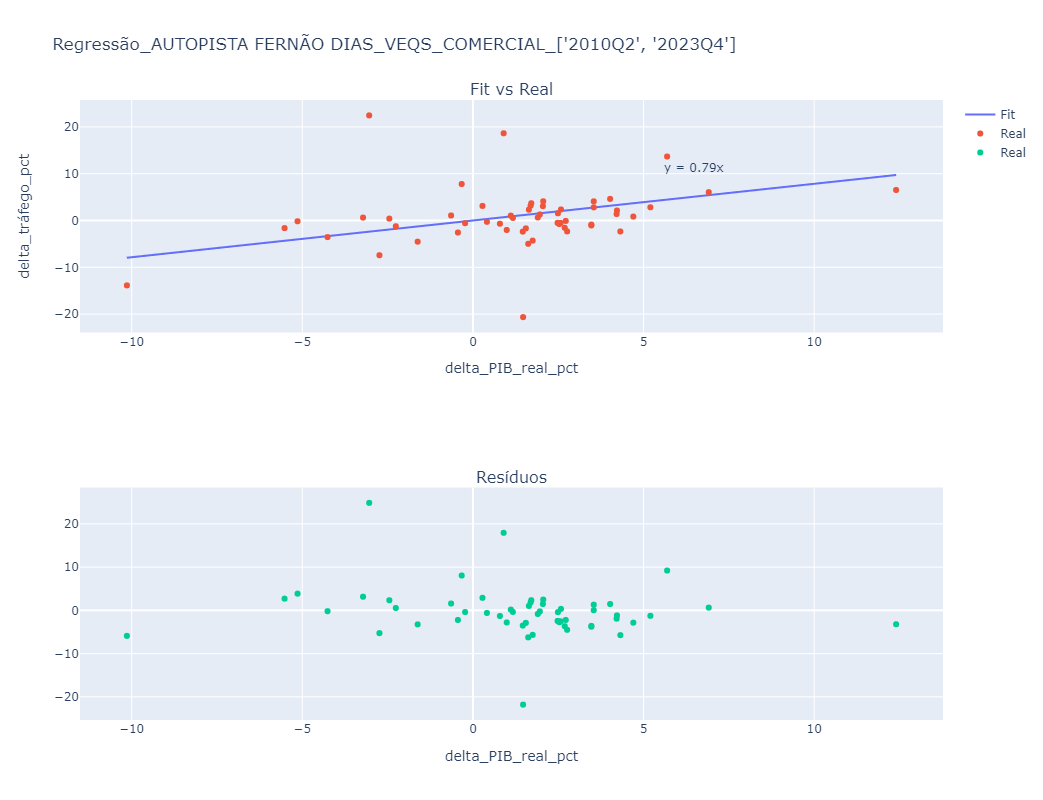

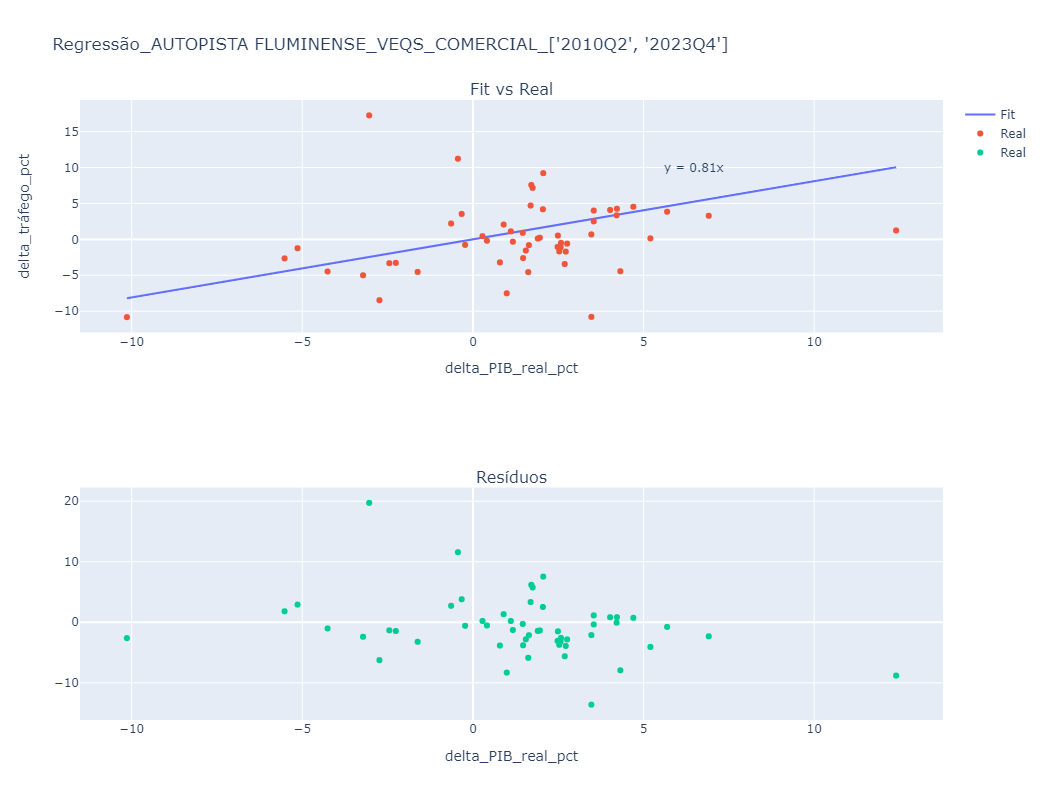

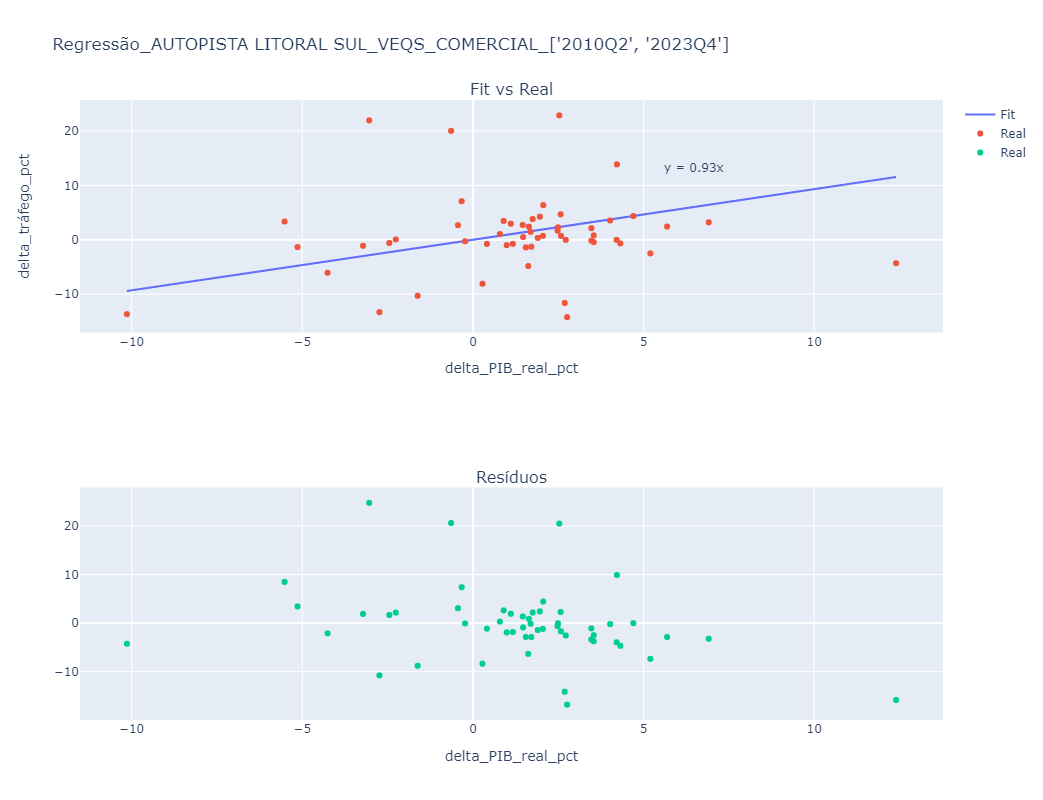

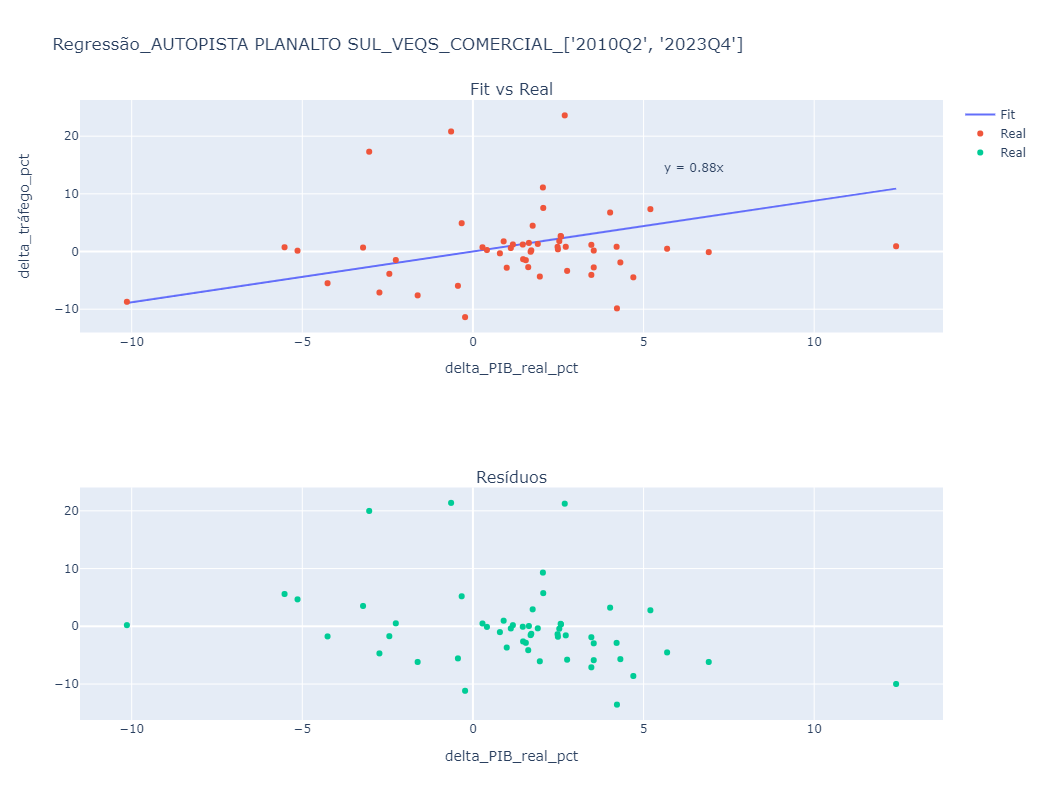

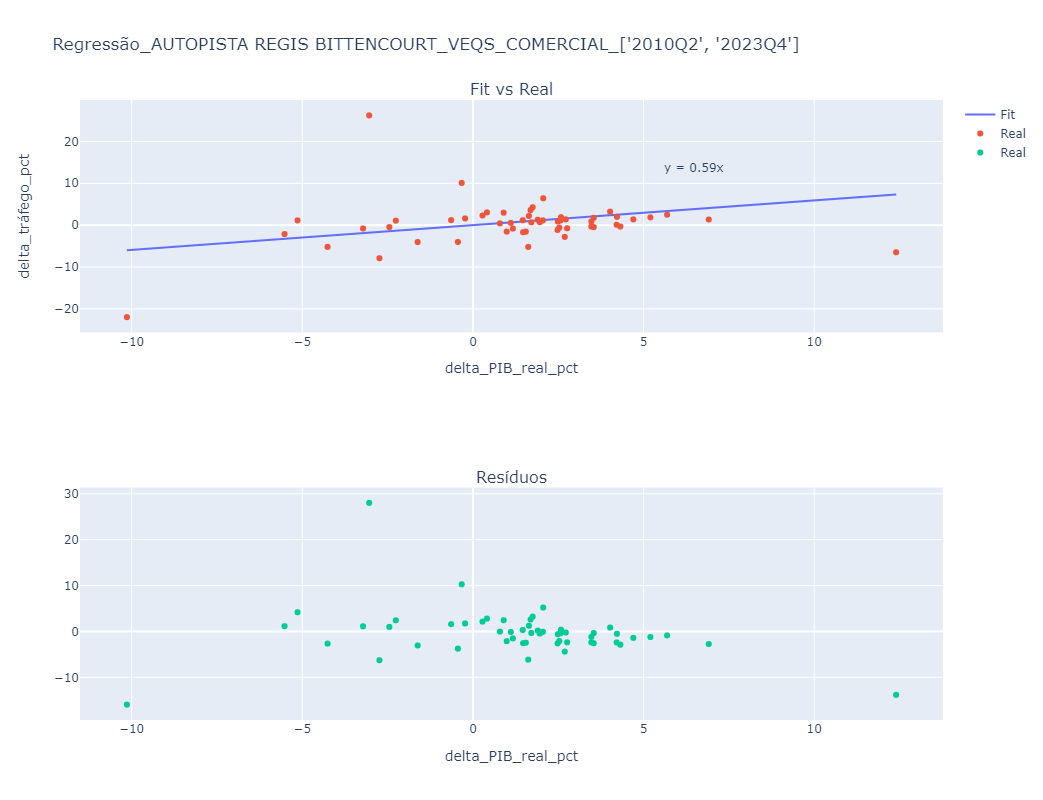

CONCEBRA_VEQS_COMERCIAL: dado não disponível


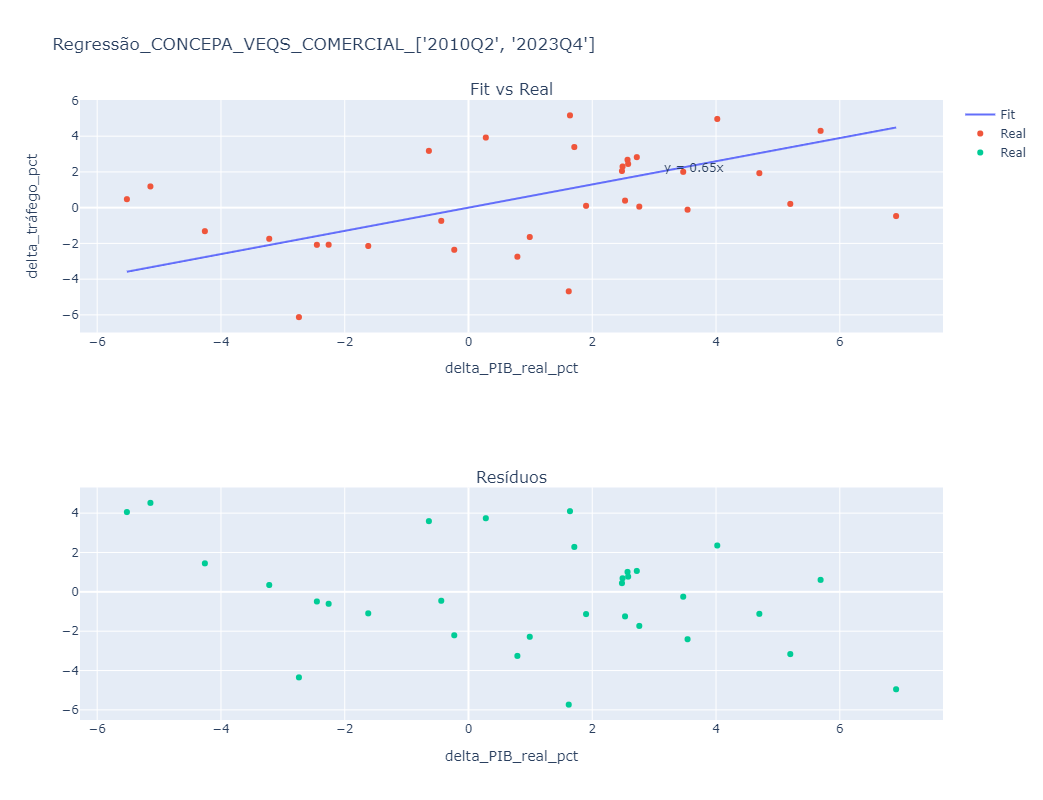

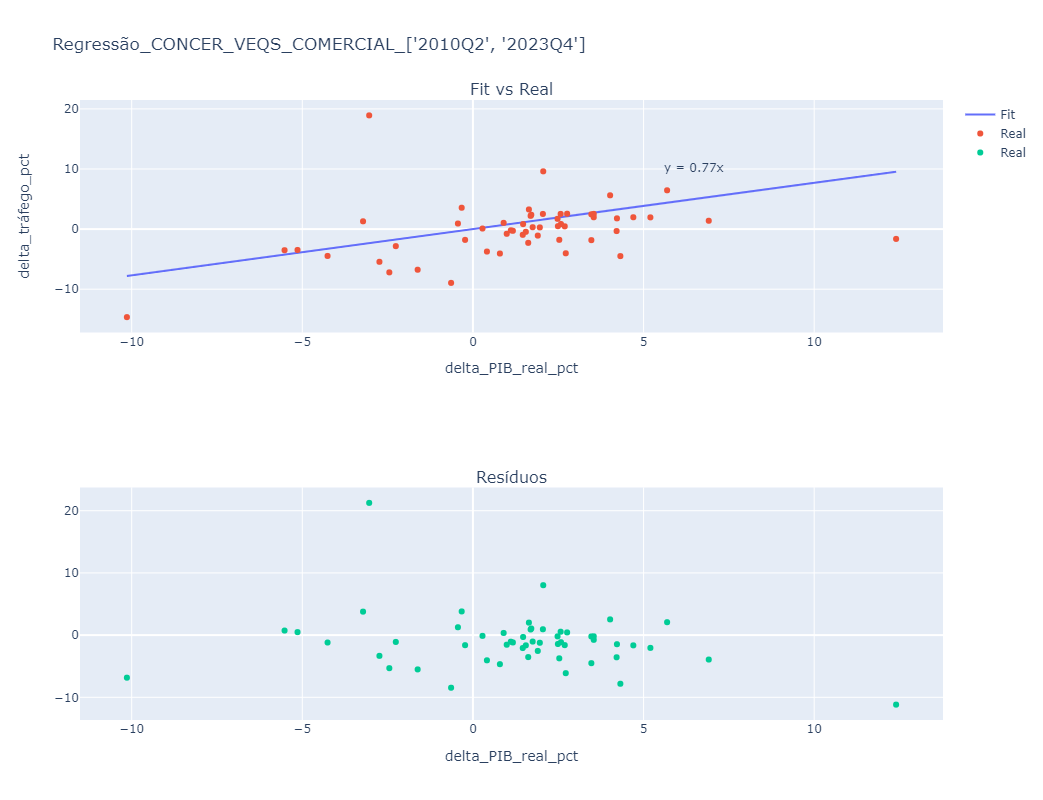

CRO_VEQS_COMERCIAL: dado não disponível


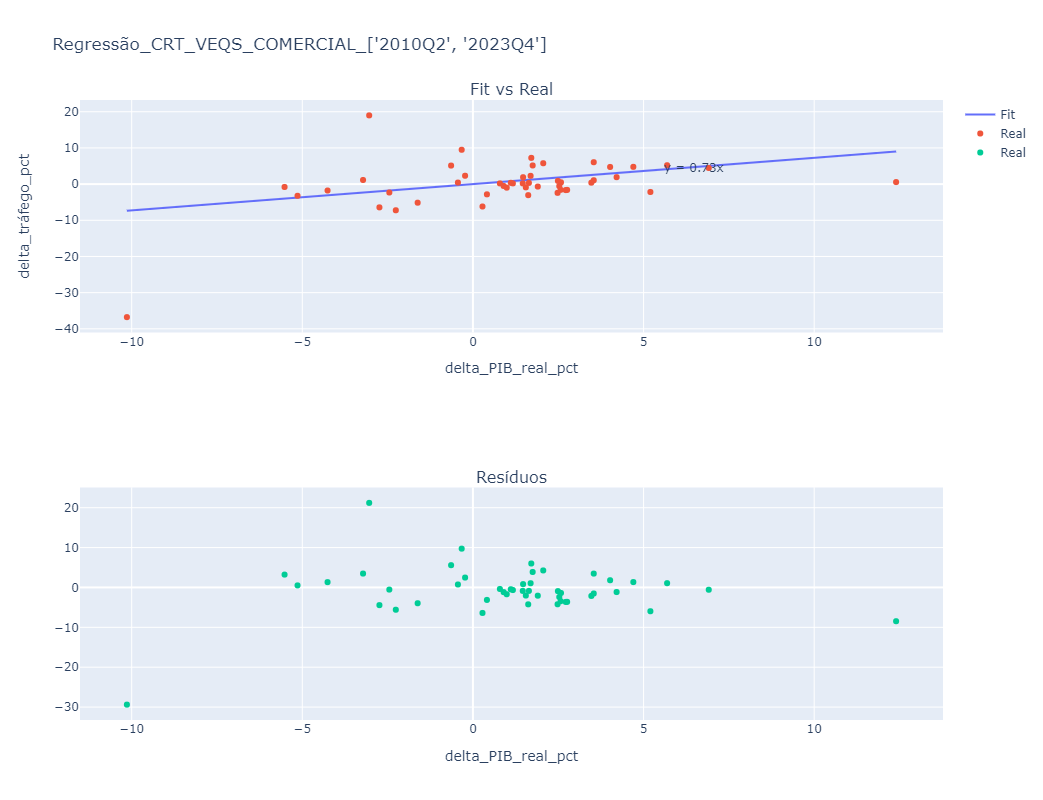

ECO050_VEQS_COMERCIAL: dado não disponível
ECO101 CONCESSIONARIA DE RODOVIAS S/A_VEQS_COMERCIAL: dado não disponível
ECOPONTE_VEQS_COMERCIAL: dado não disponível


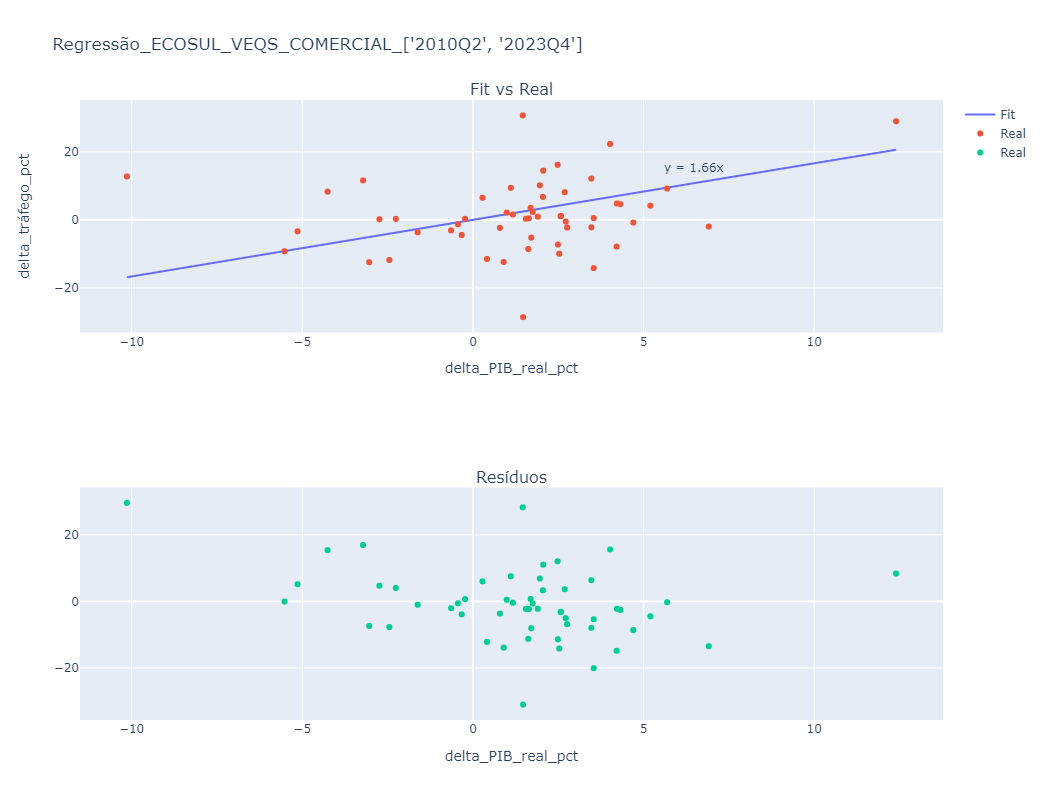

ECOVIAS DO CERRADO_VEQS_COMERCIAL: dado não disponível
MSVIA_VEQS_COMERCIAL: dado não disponível
NOVADUTRA_VEQS_COMERCIAL: dado não disponível


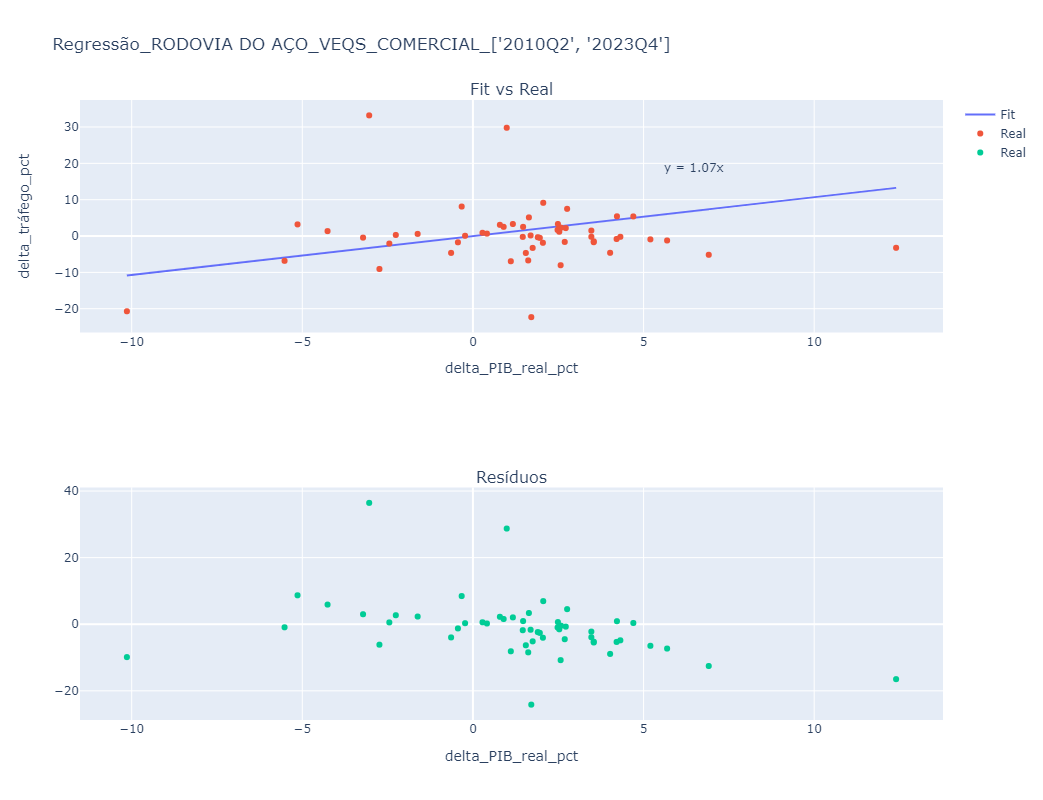

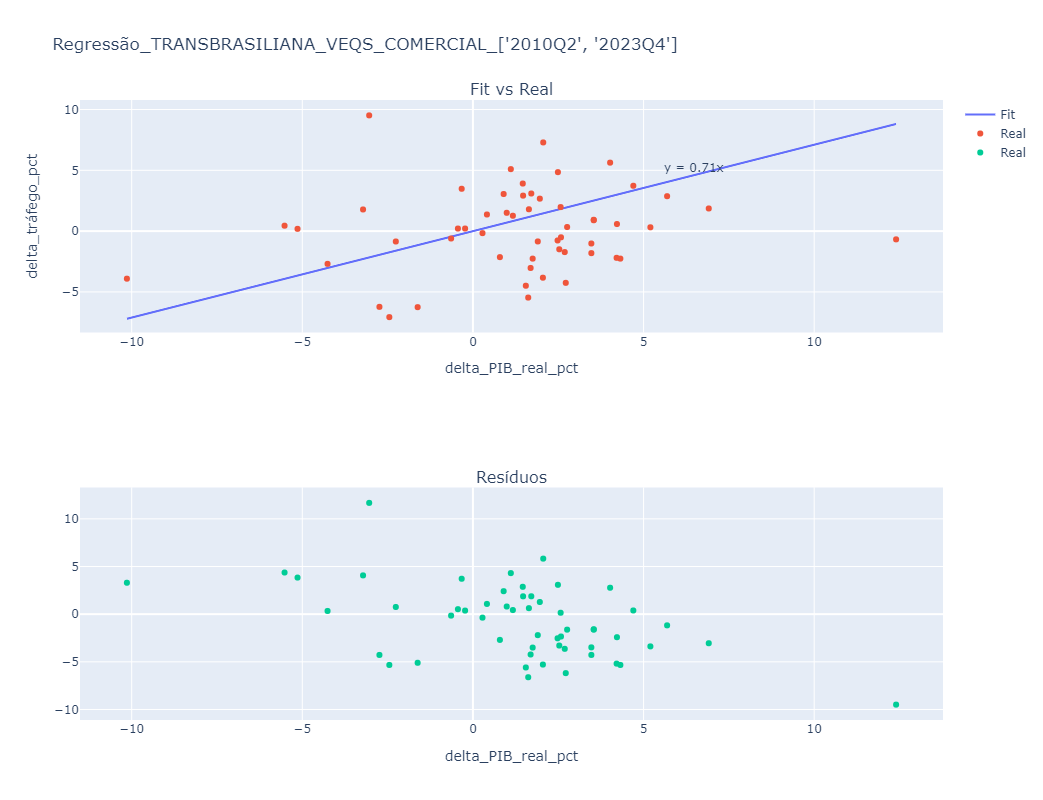

VIA 040_VEQS_COMERCIAL: dado não disponível
VIA BAHIA_VEQS_COMERCIAL: dado não disponível
VIA SUL_VEQS_COMERCIAL: dado não disponível


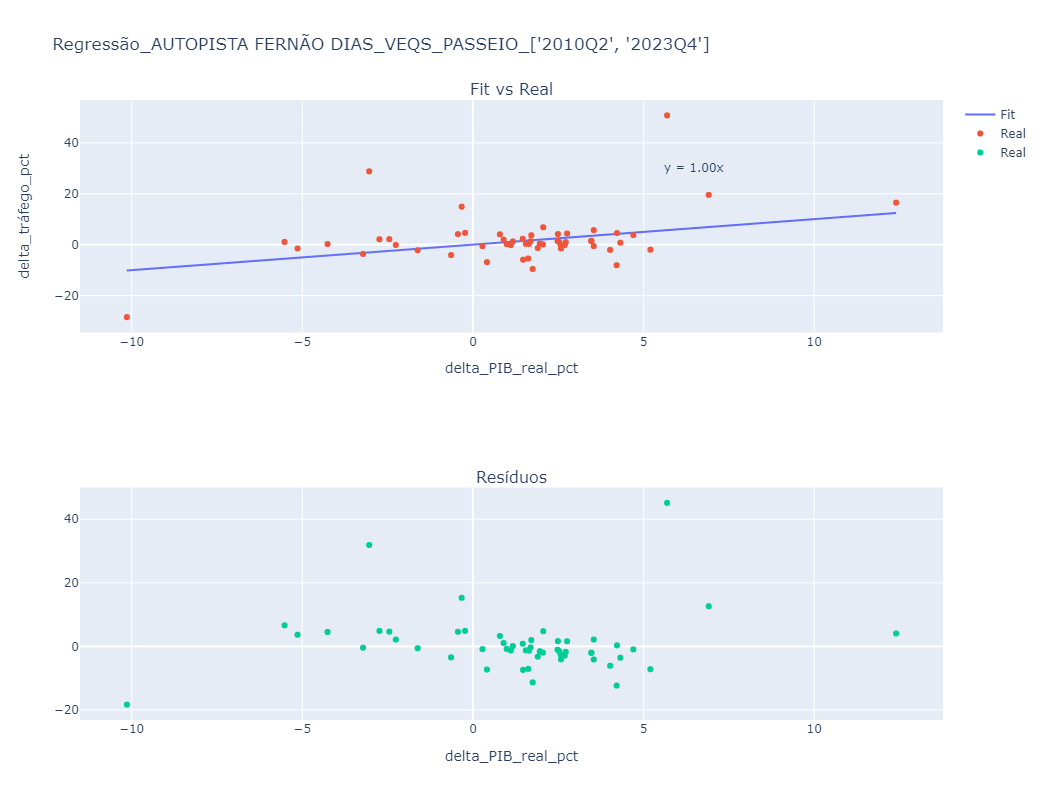

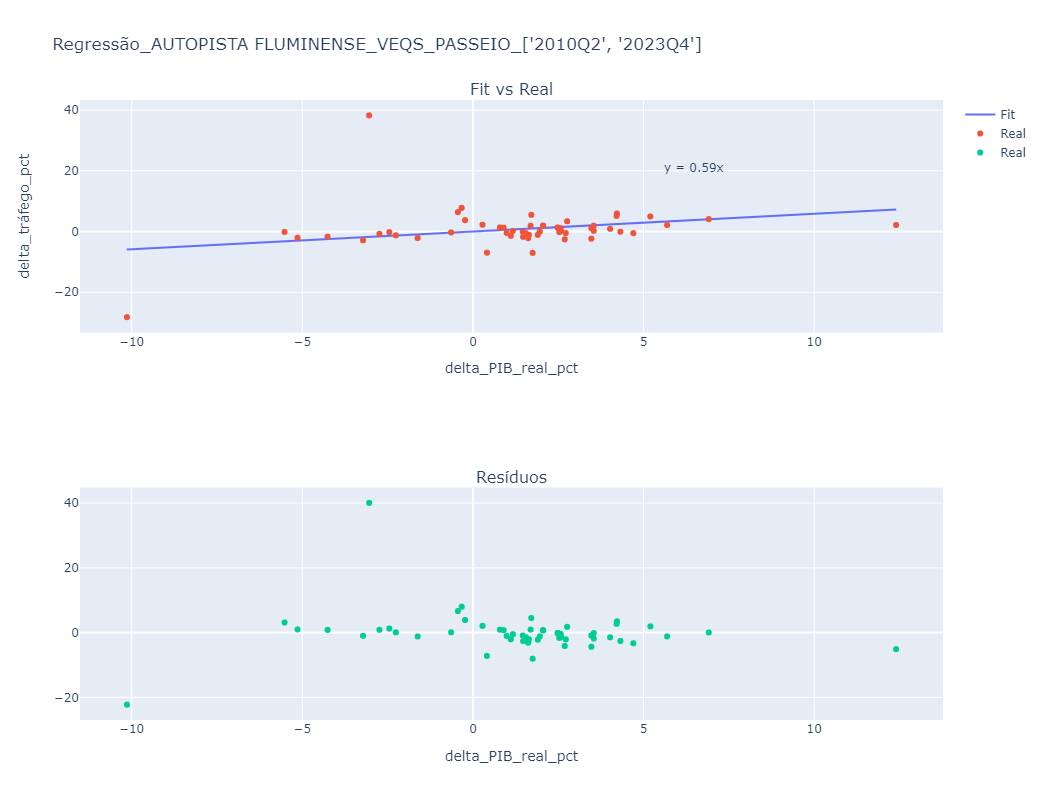

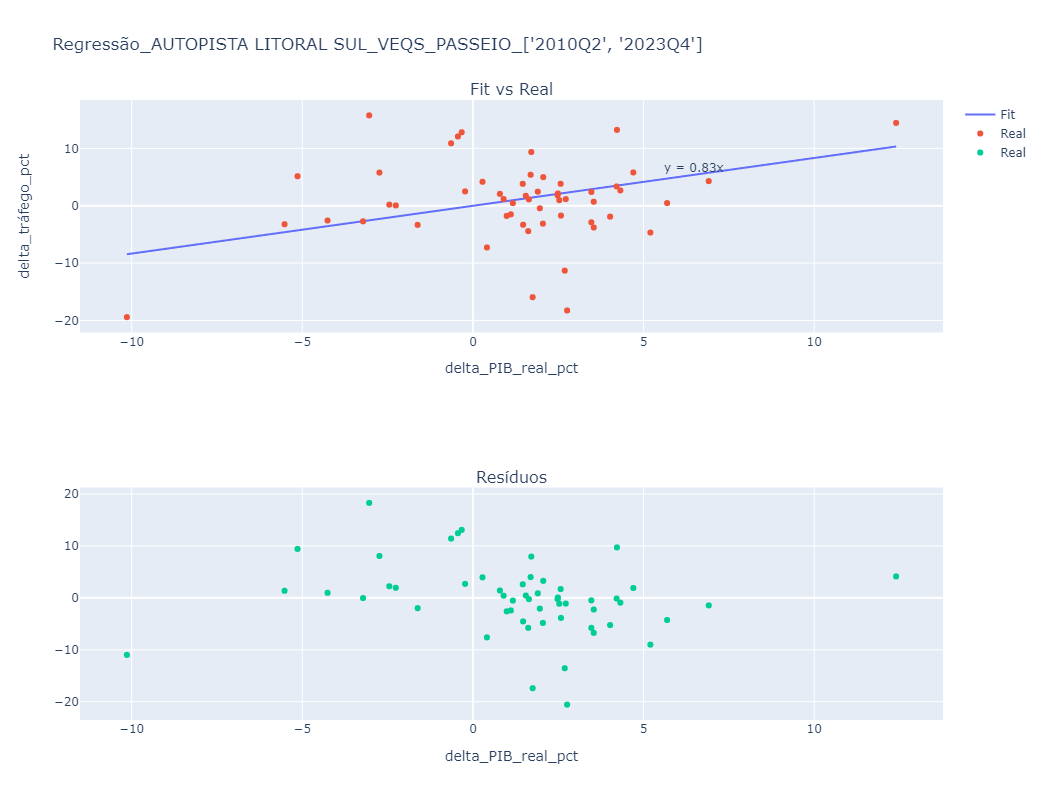

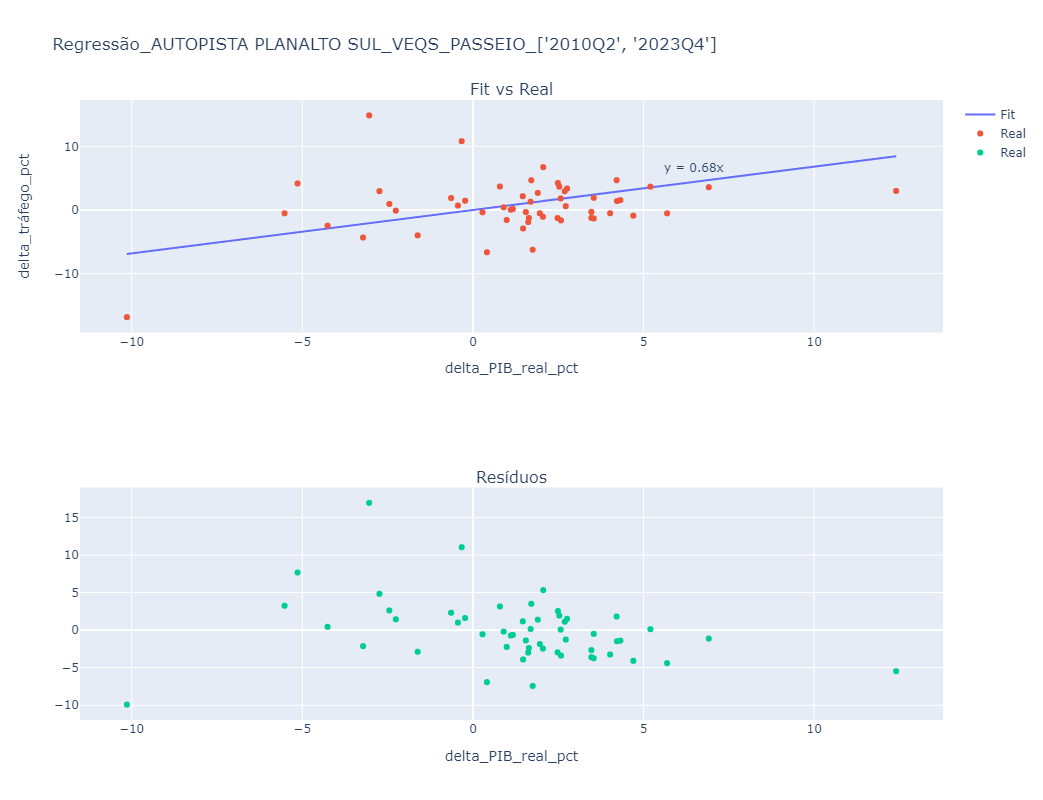

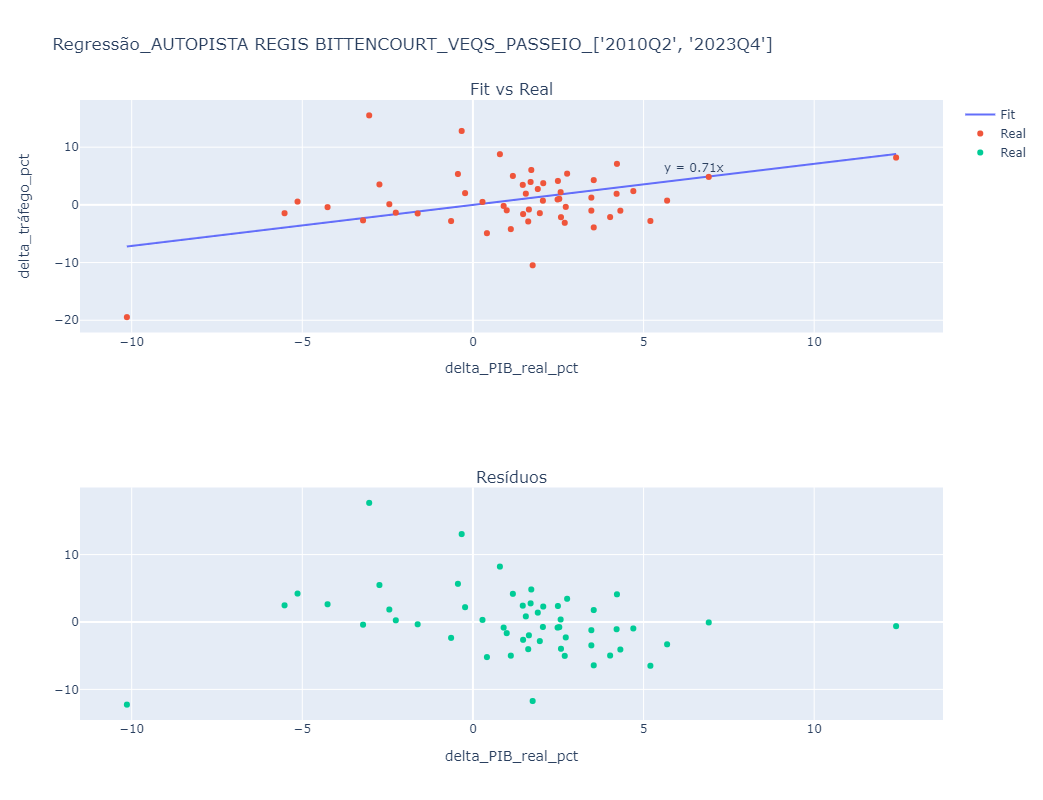

CONCEBRA_VEQS_PASSEIO: dado não disponível


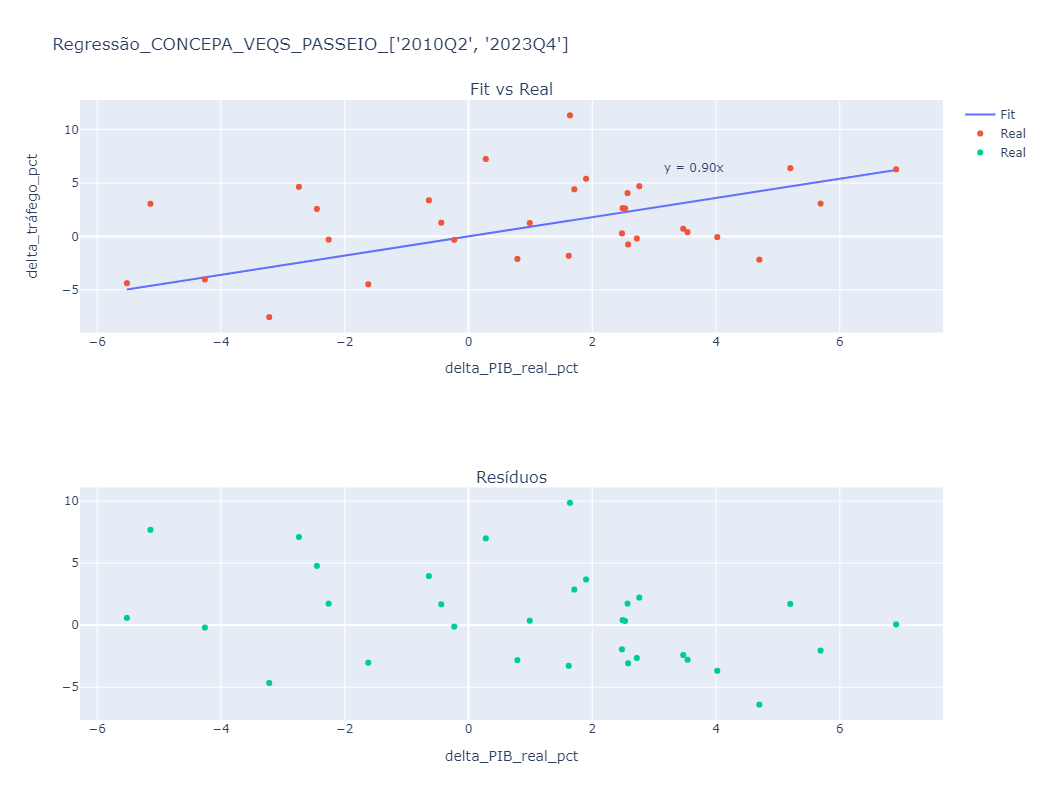

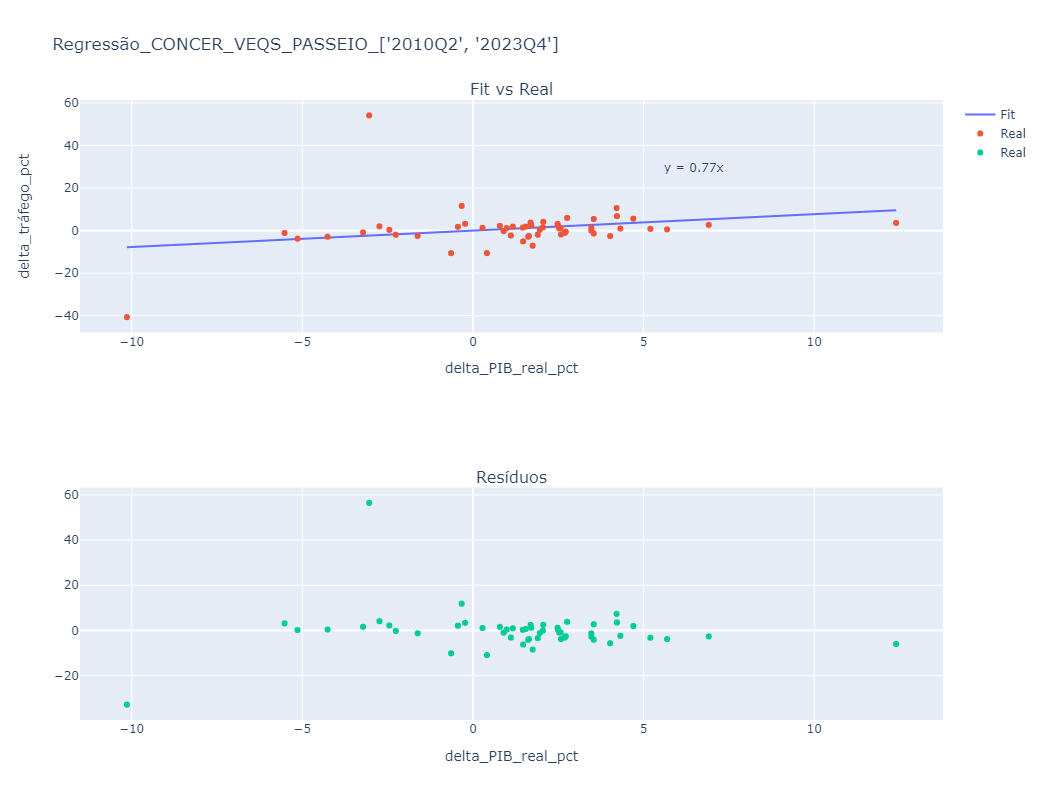

CRO_VEQS_PASSEIO: dado não disponível


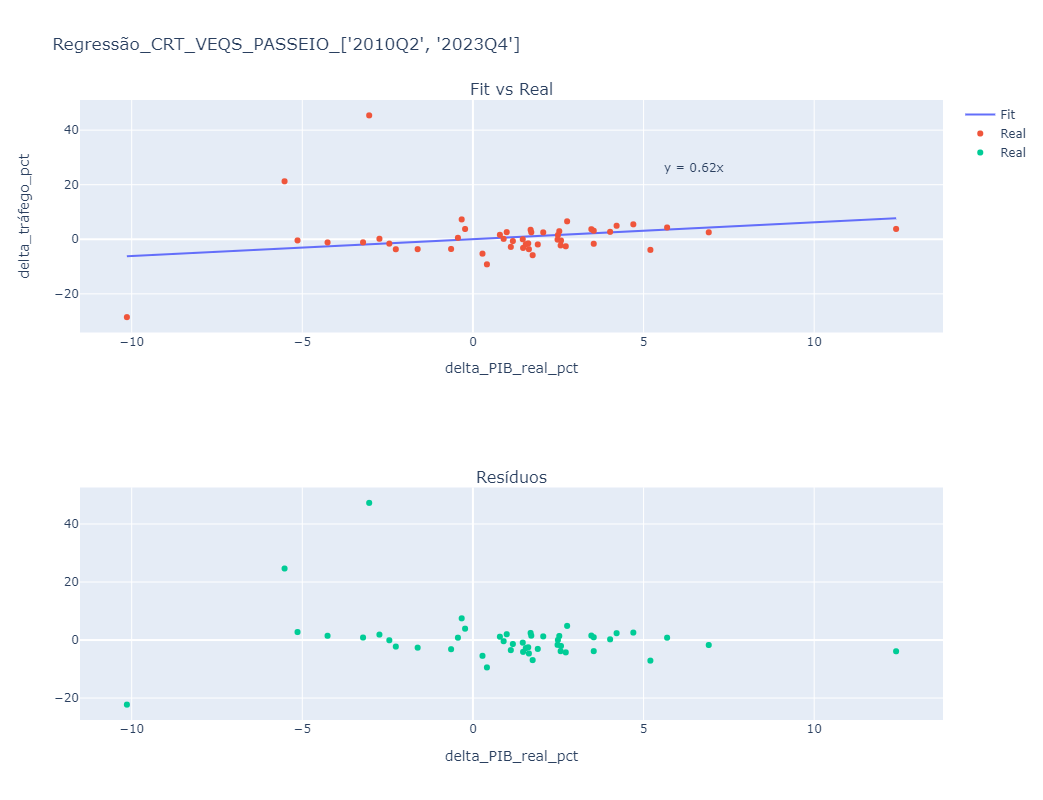

ECO050_VEQS_PASSEIO: dado não disponível
ECO101 CONCESSIONARIA DE RODOVIAS S/A_VEQS_PASSEIO: dado não disponível
ECOPONTE_VEQS_PASSEIO: dado não disponível


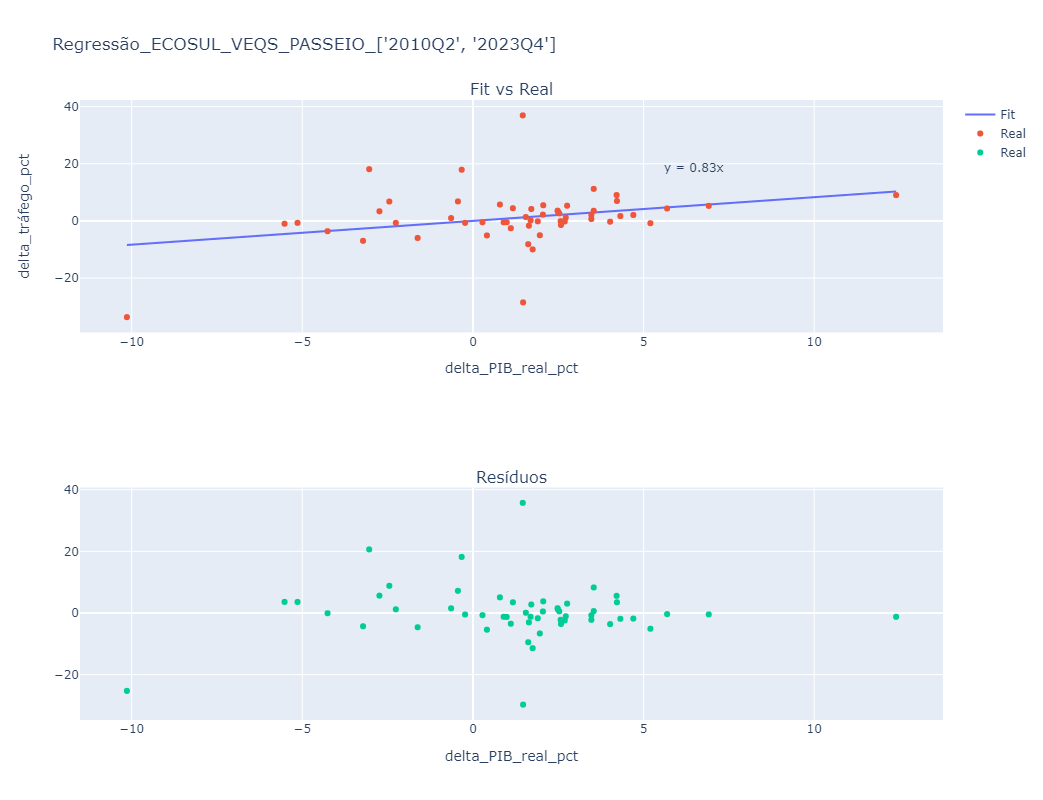

ECOVIAS DO CERRADO_VEQS_PASSEIO: dado não disponível
MSVIA_VEQS_PASSEIO: dado não disponível
NOVADUTRA_VEQS_PASSEIO: dado não disponível


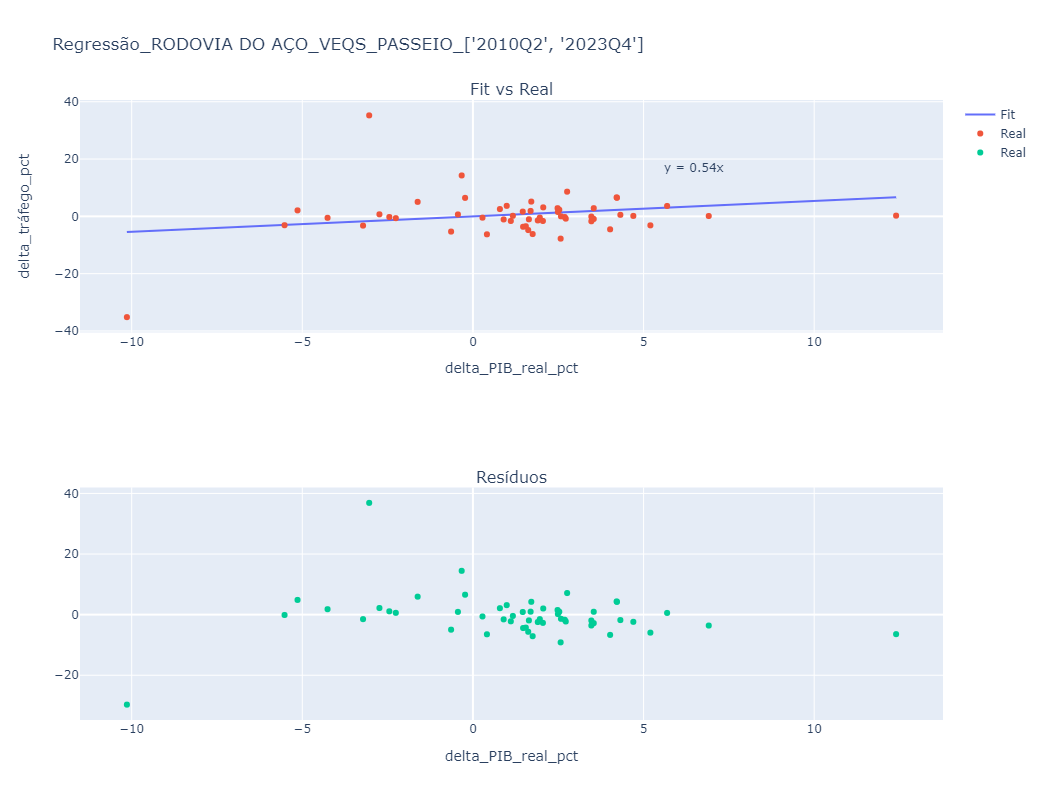

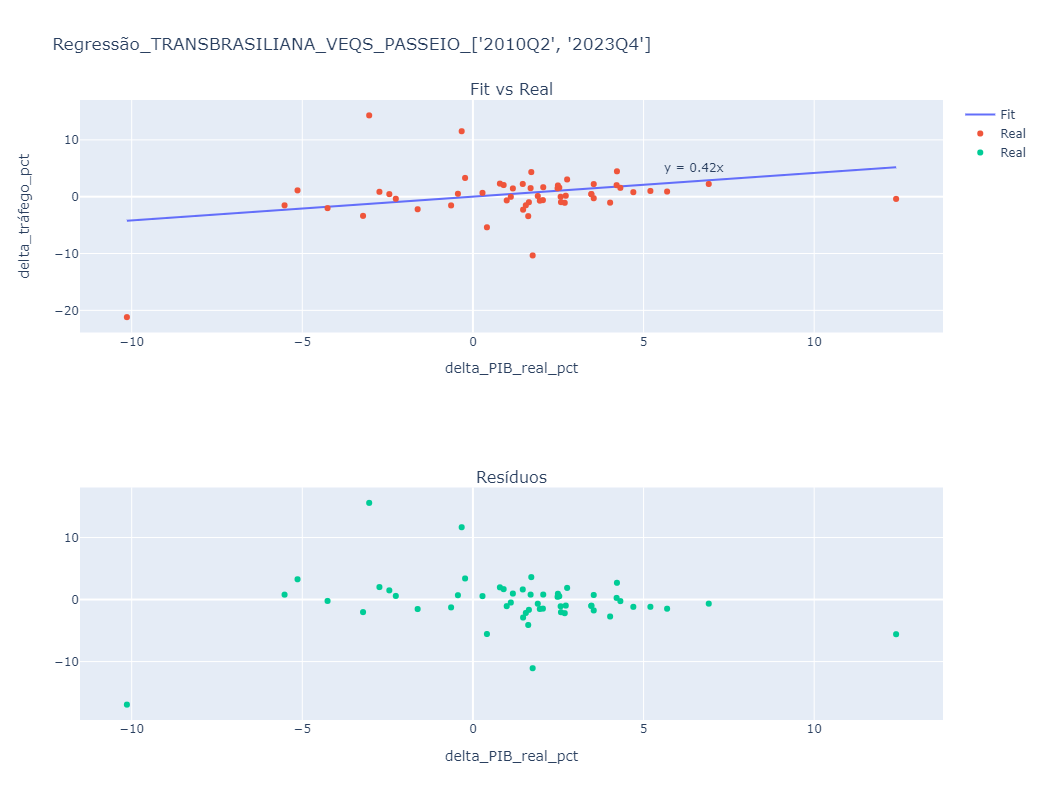

VIA 040_VEQS_PASSEIO: dado não disponível
VIA BAHIA_VEQS_PASSEIO: dado não disponível
VIA SUL_VEQS_PASSEIO: dado não disponível


In [42]:
for veq, _dict in dict_curves_p1.items():
    for conc in _dict:
        fig = make_plot(_dict[conc], veq, conc, periodicidade, periodos[0])
        if fig is not None:
            fig.show()

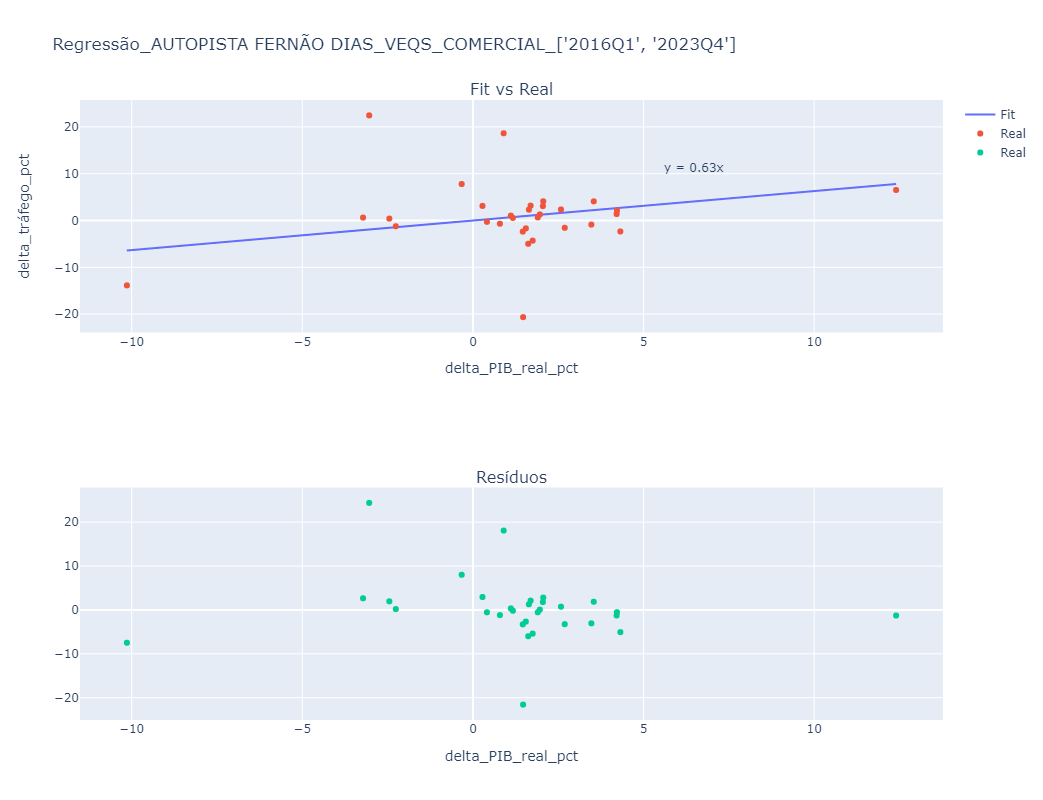

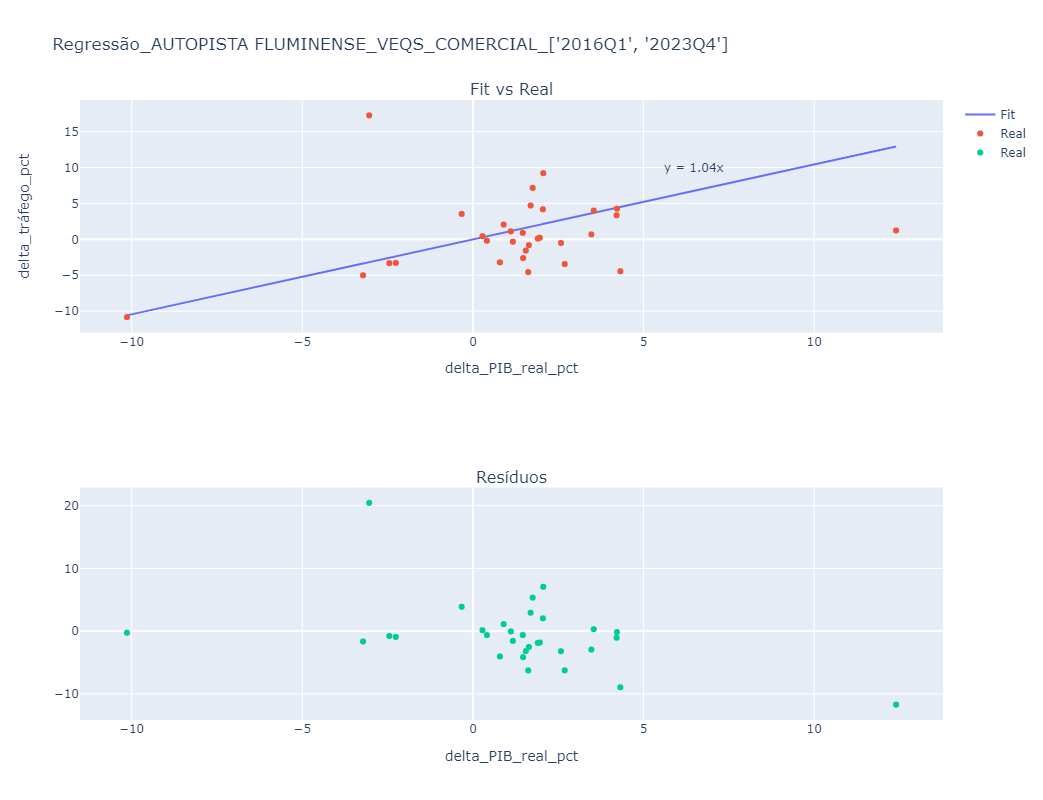

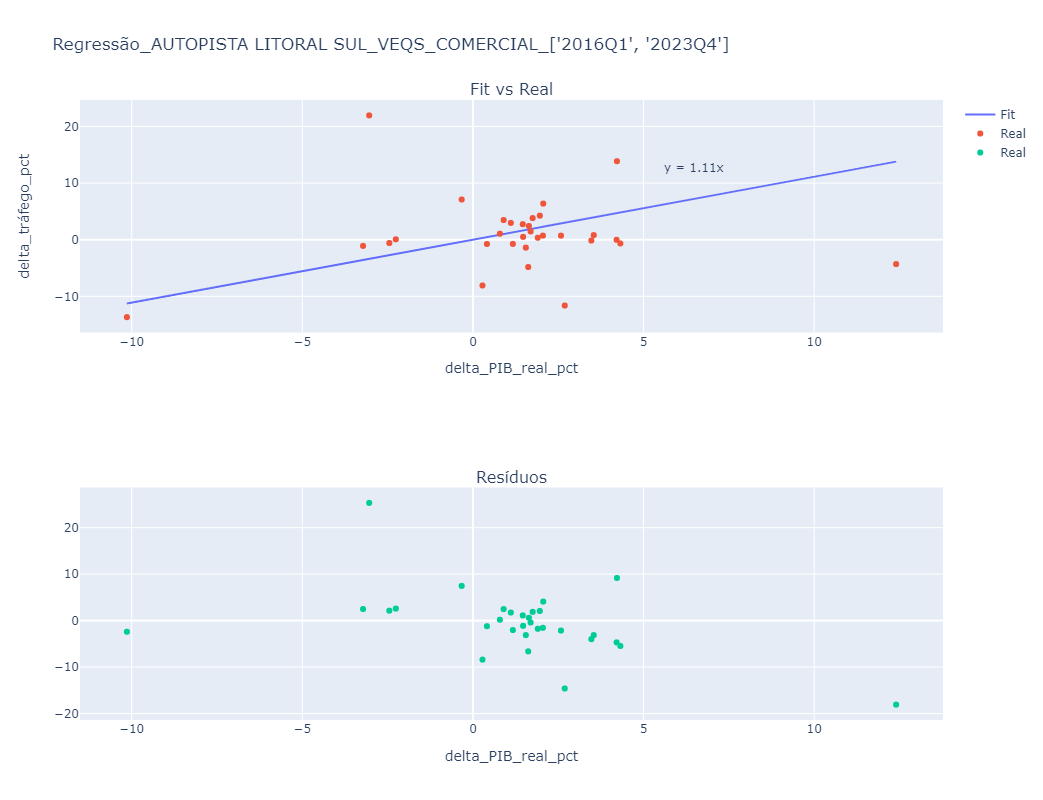

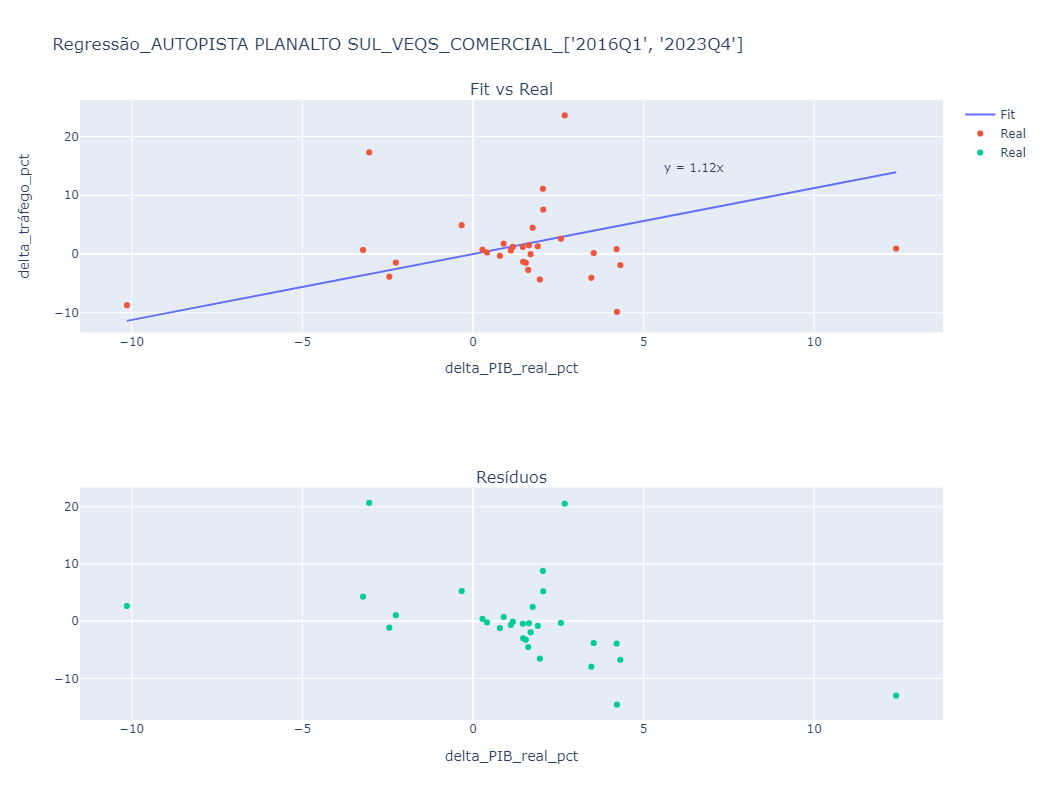

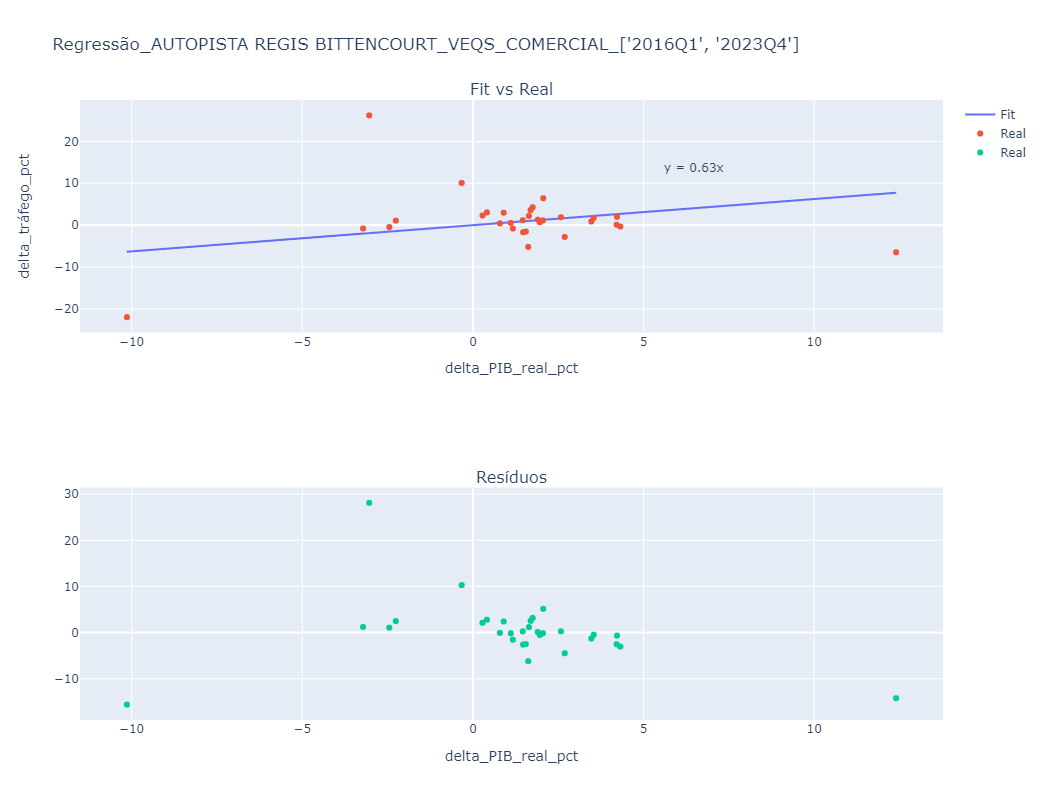

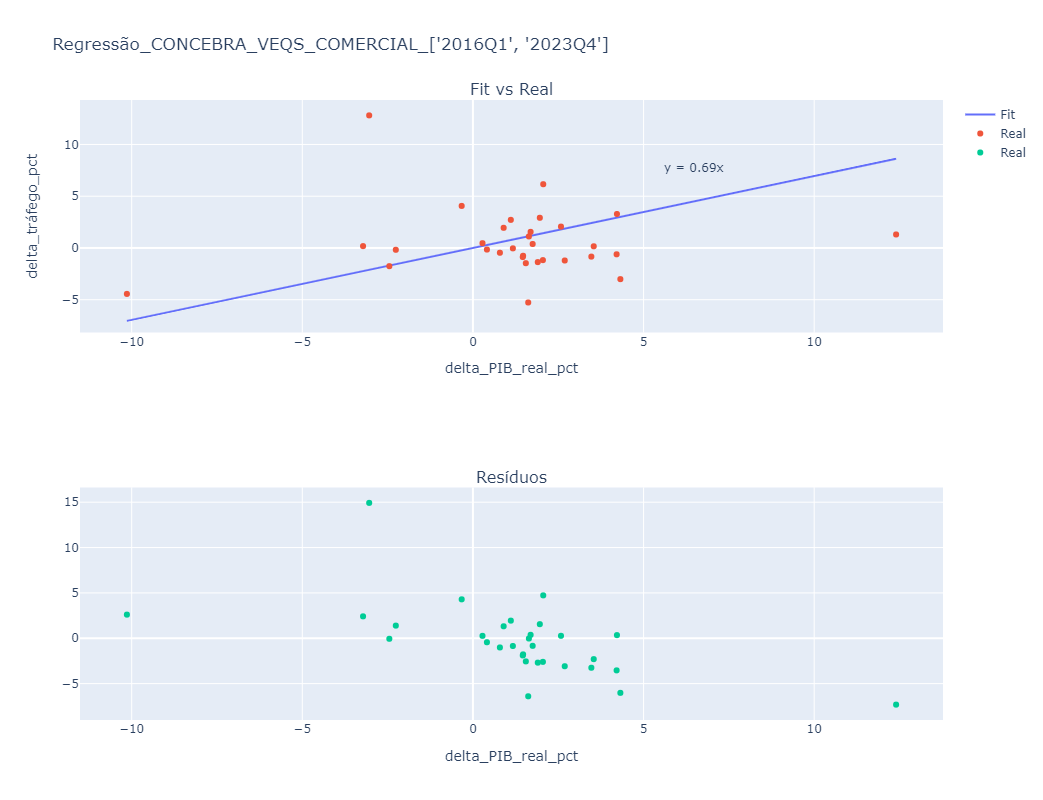

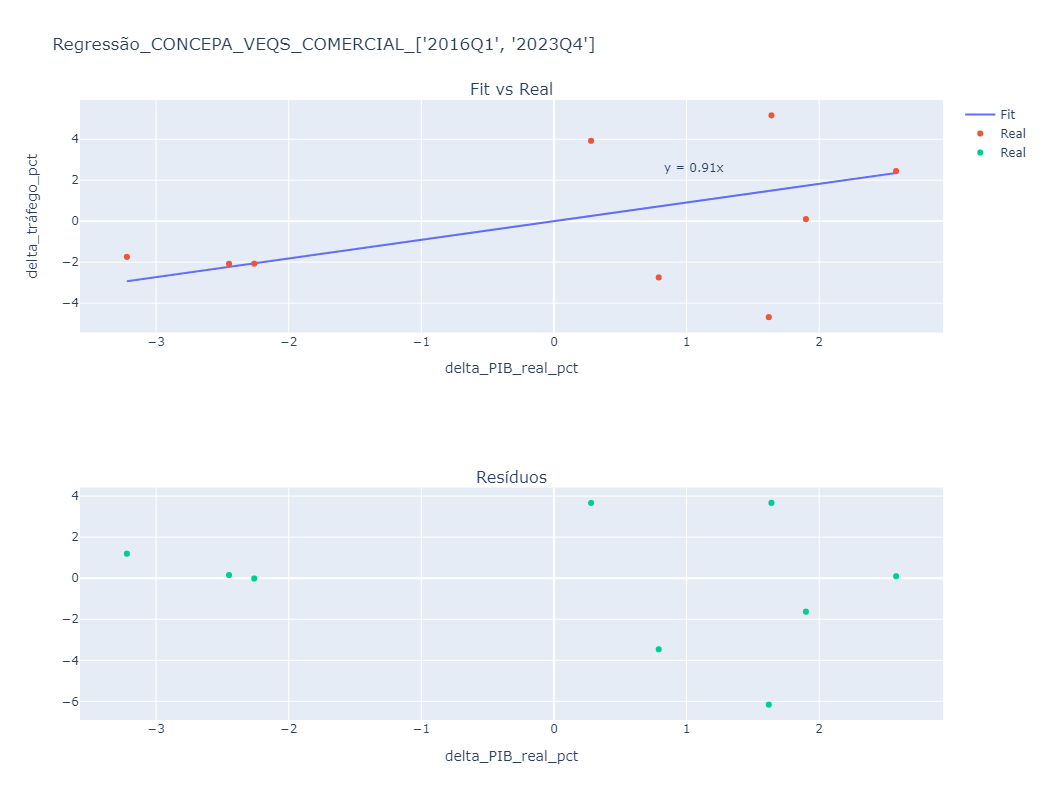

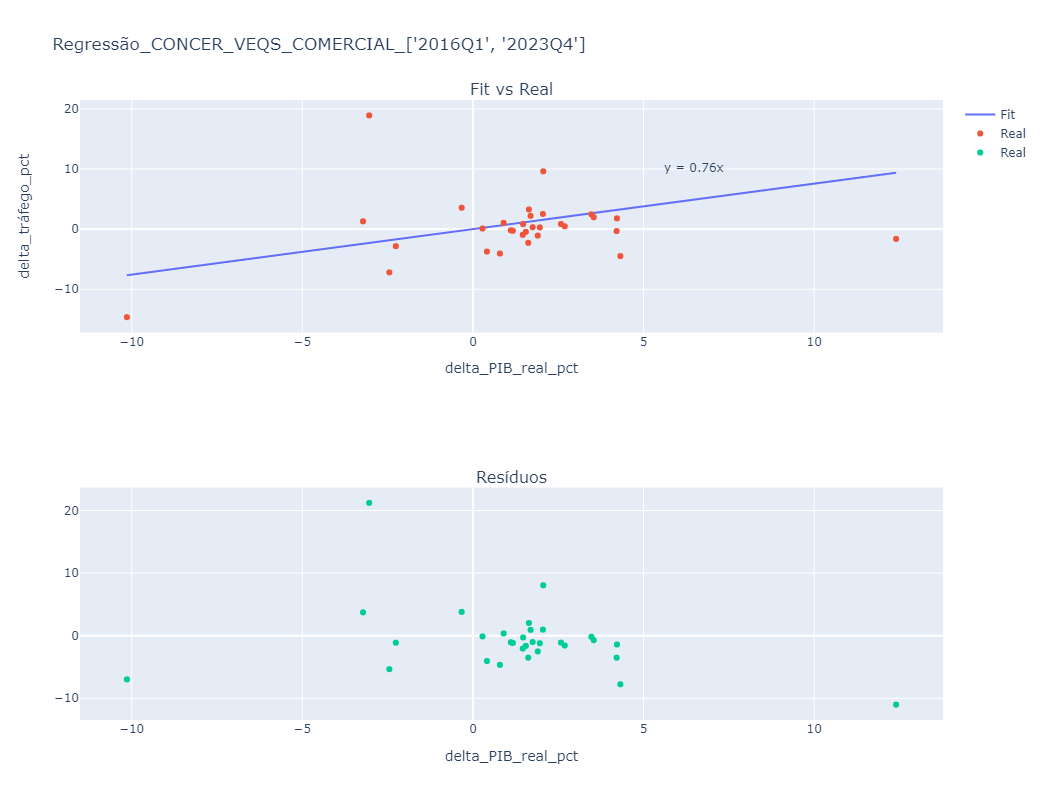

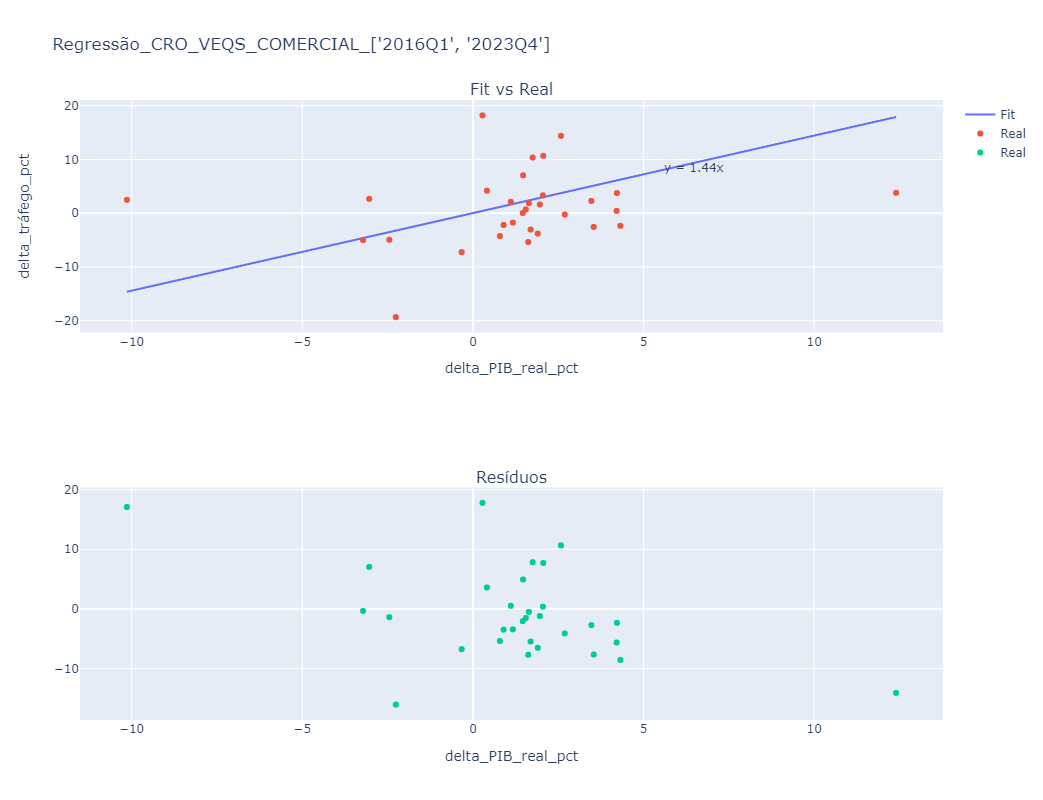

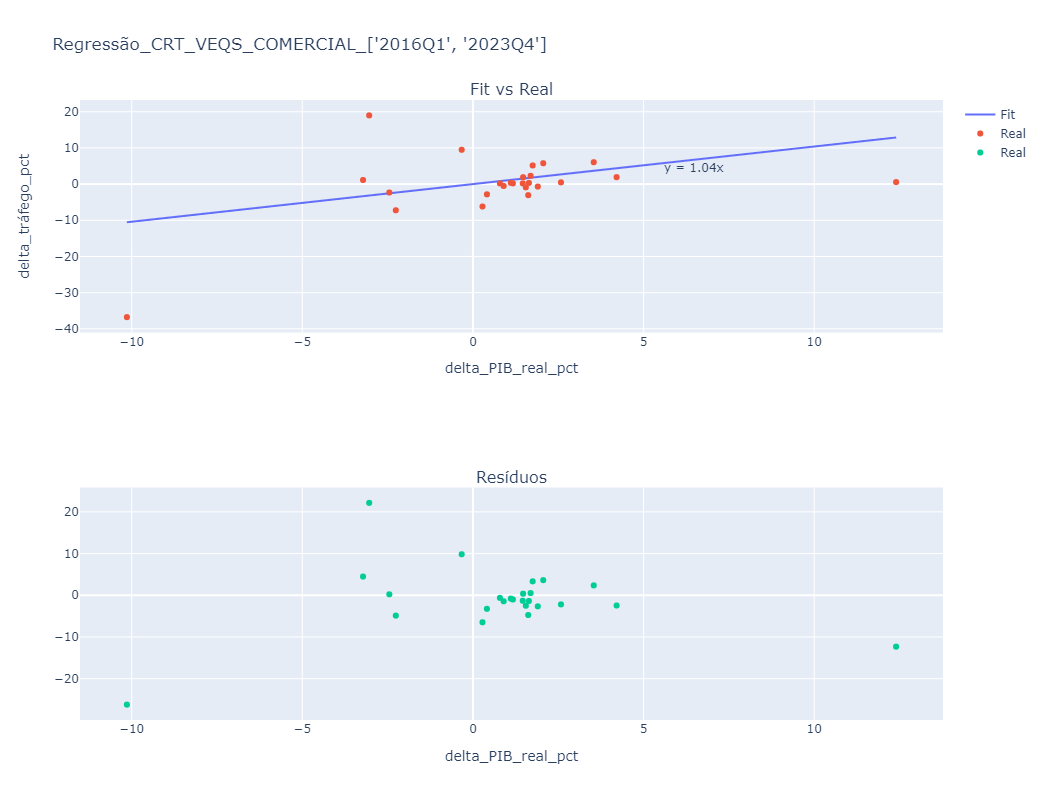

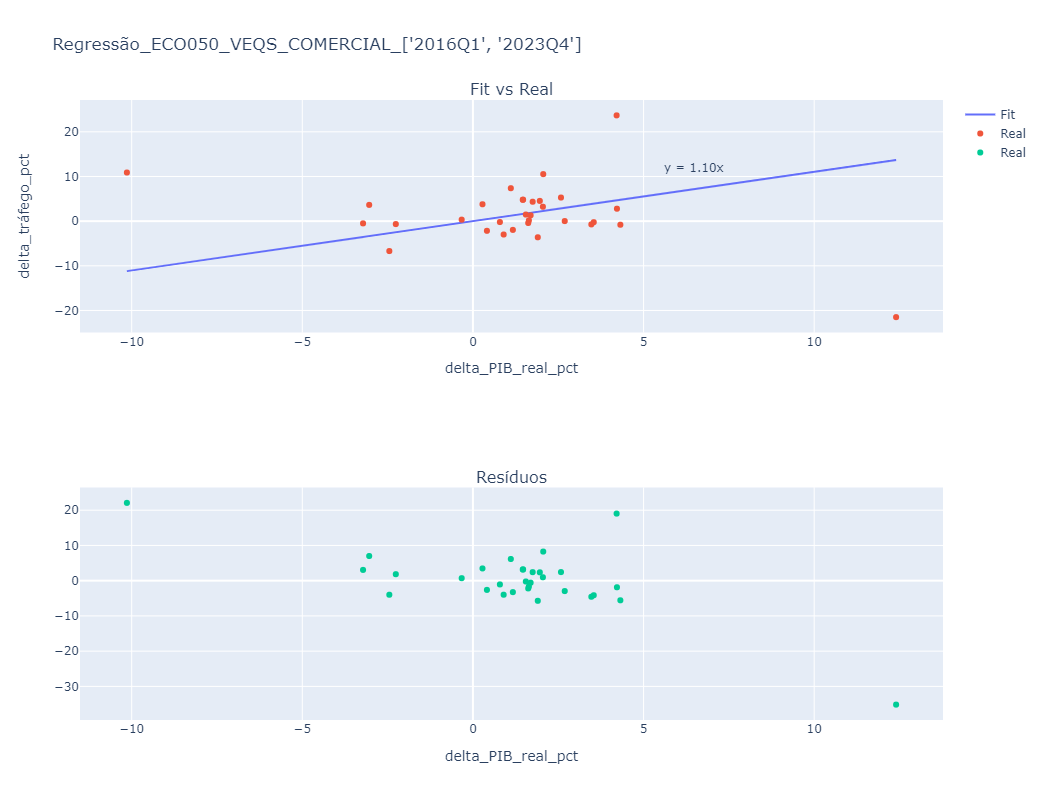

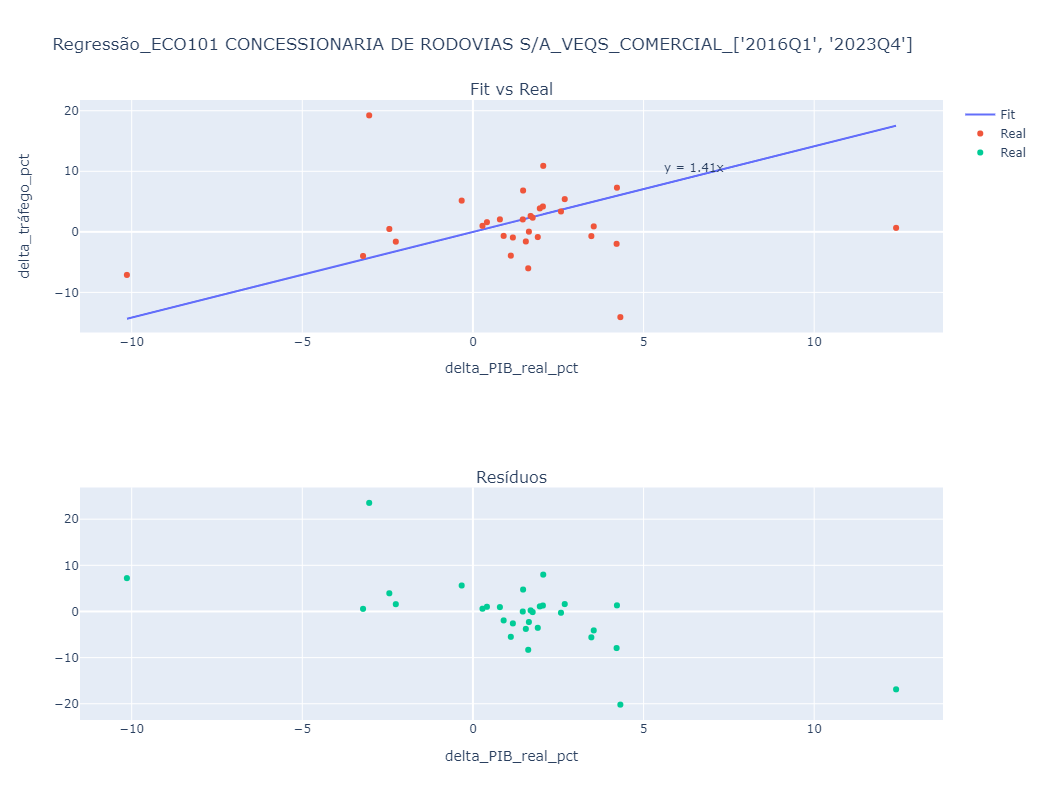

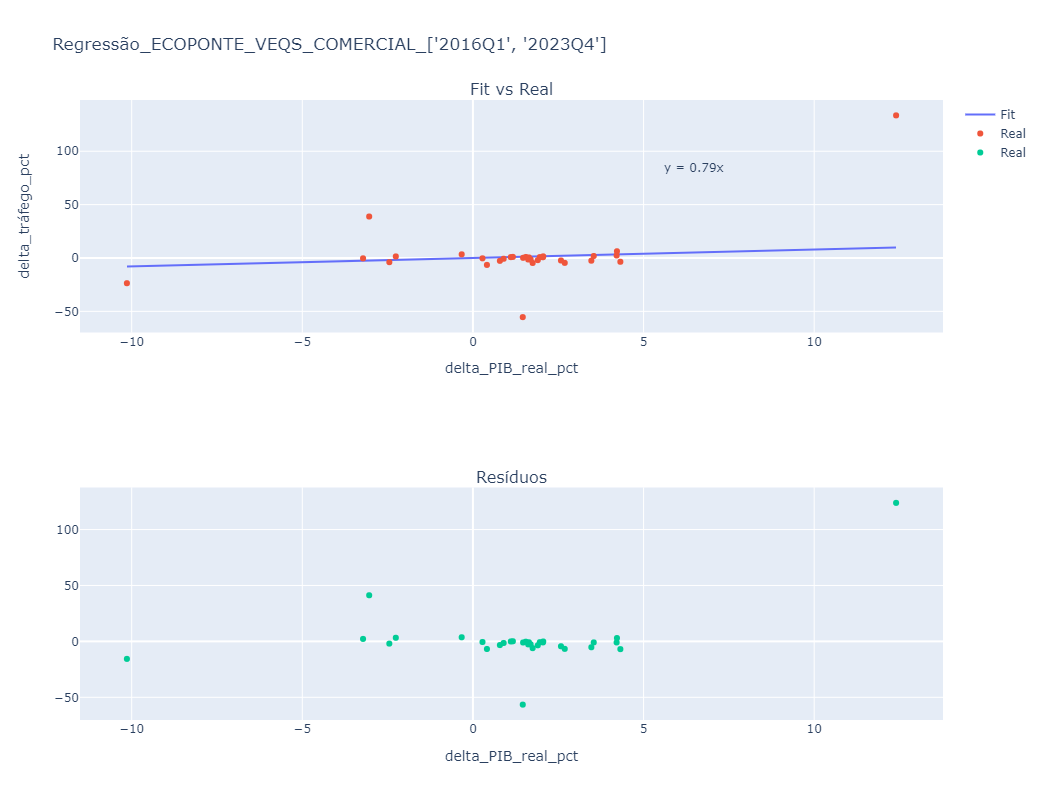

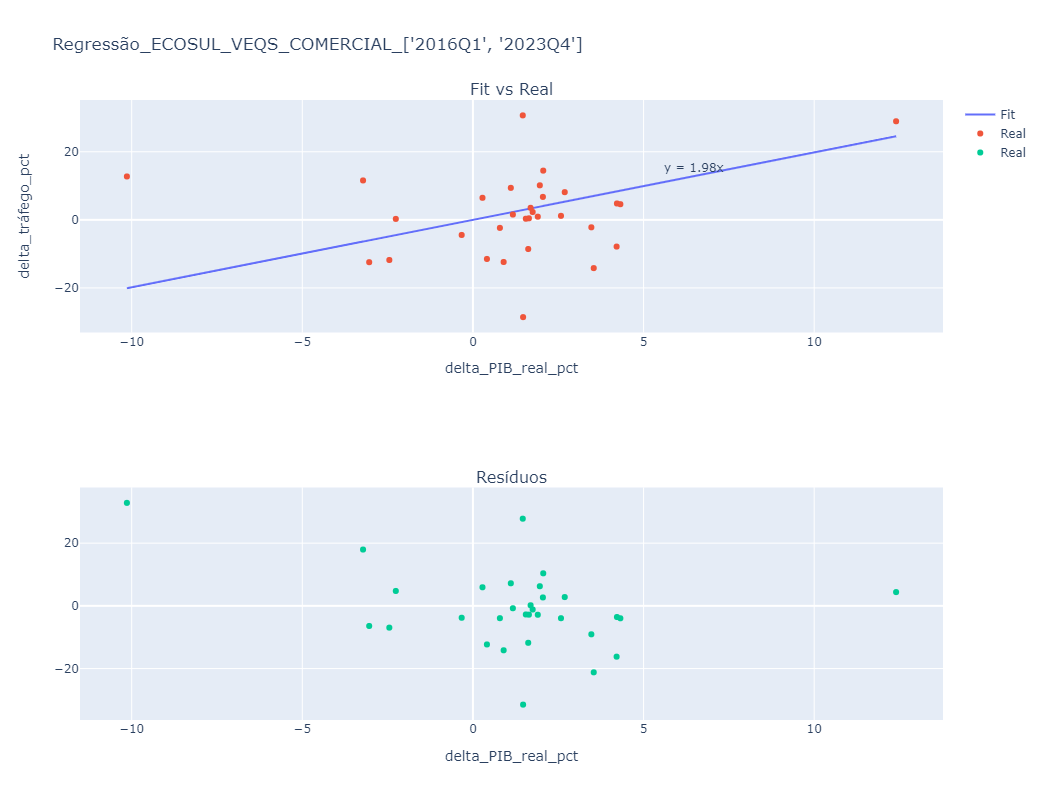

ECOVIAS DO CERRADO_VEQS_COMERCIAL: dado não disponível


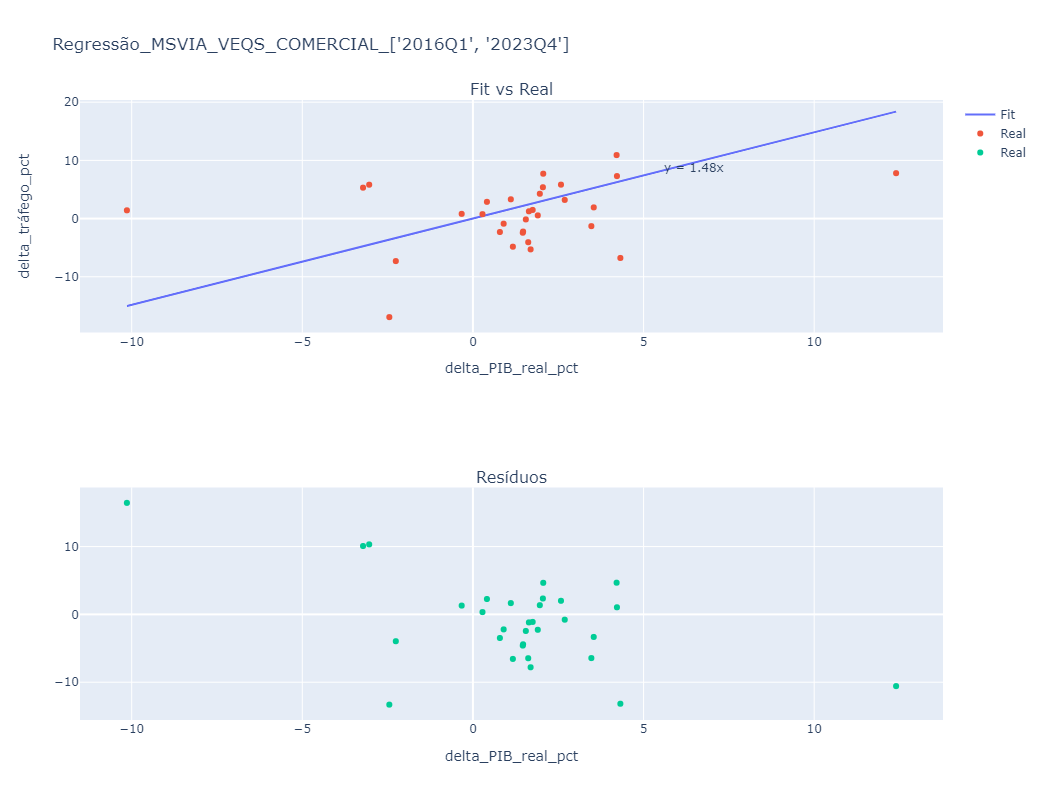

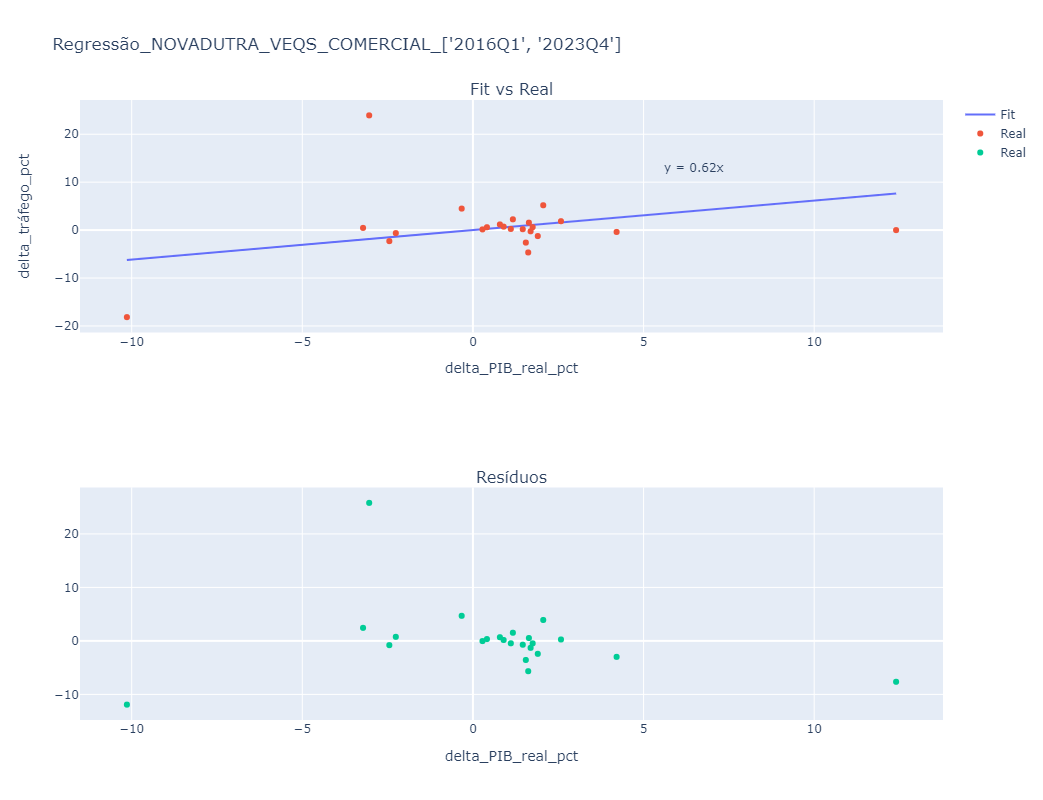

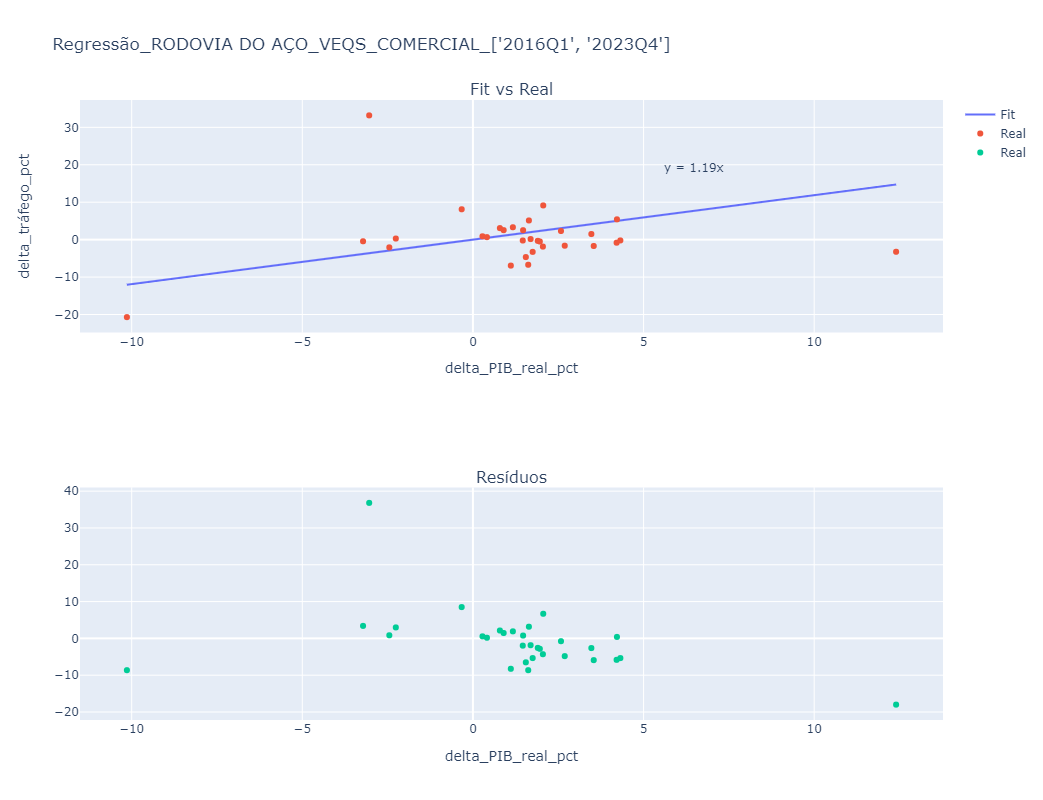

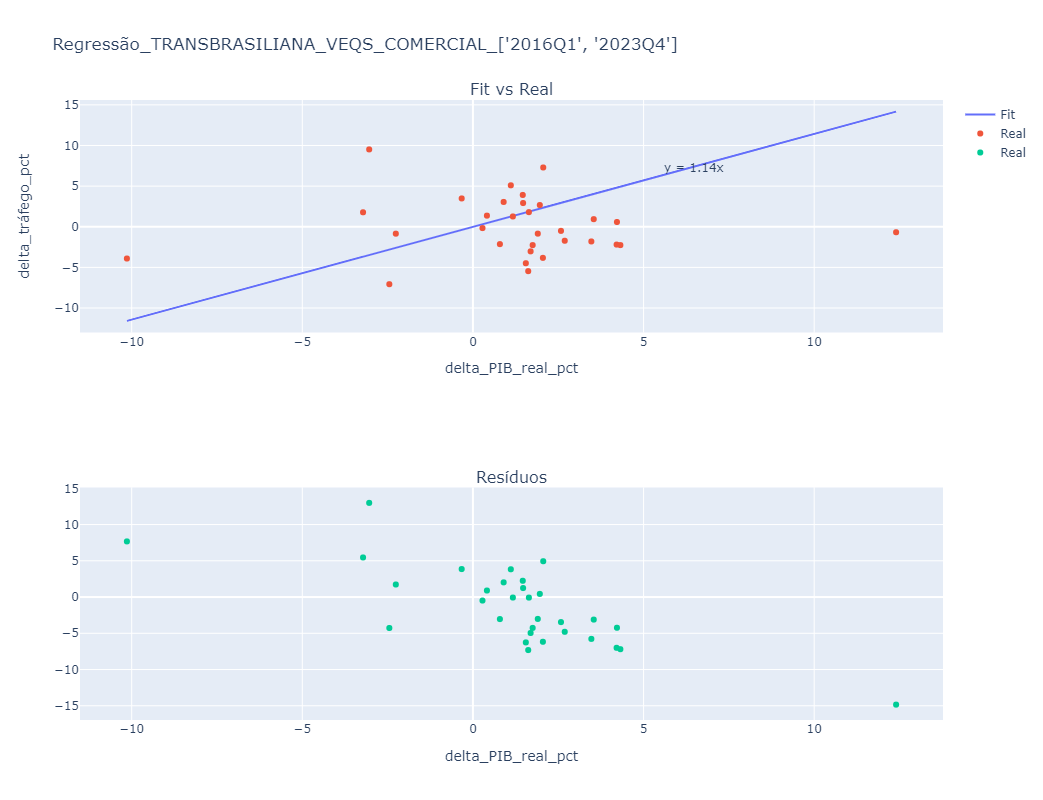

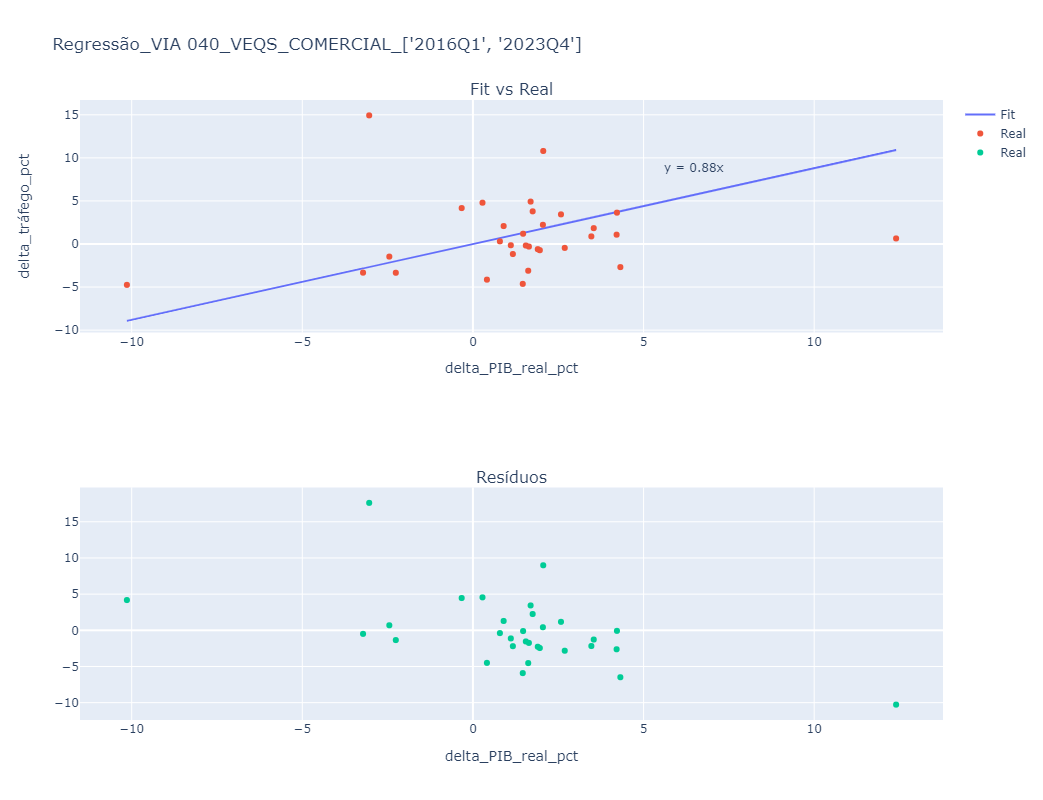

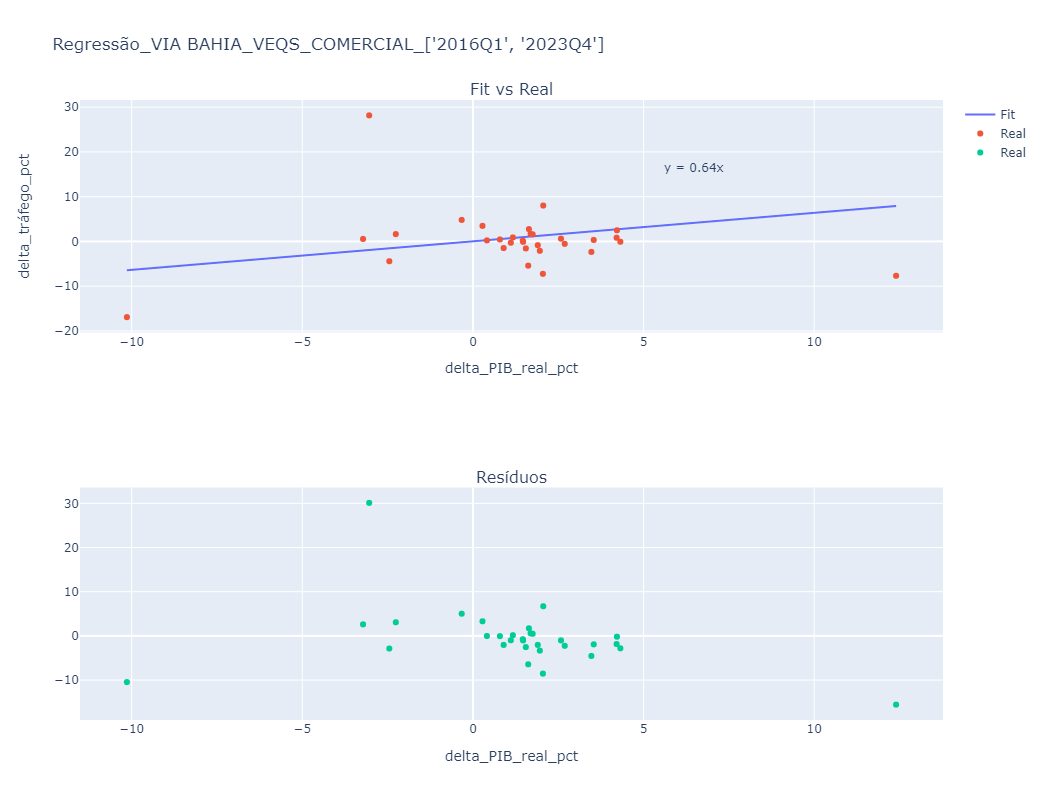

VIA SUL_VEQS_COMERCIAL: dado não disponível


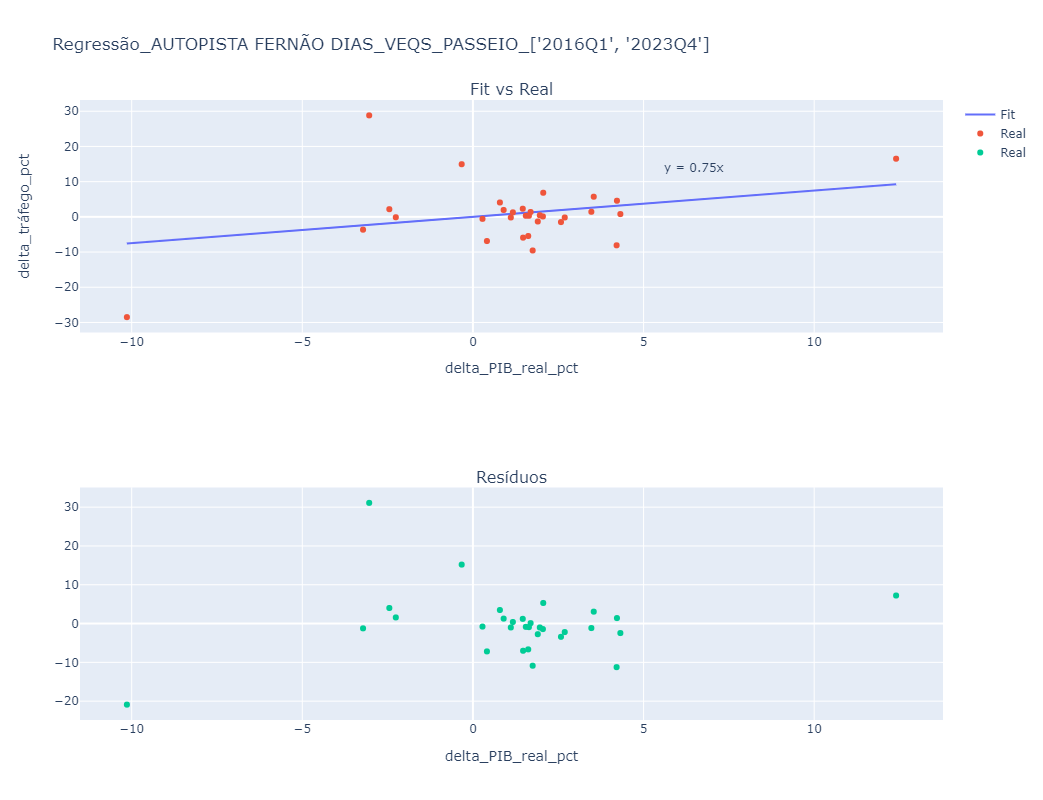

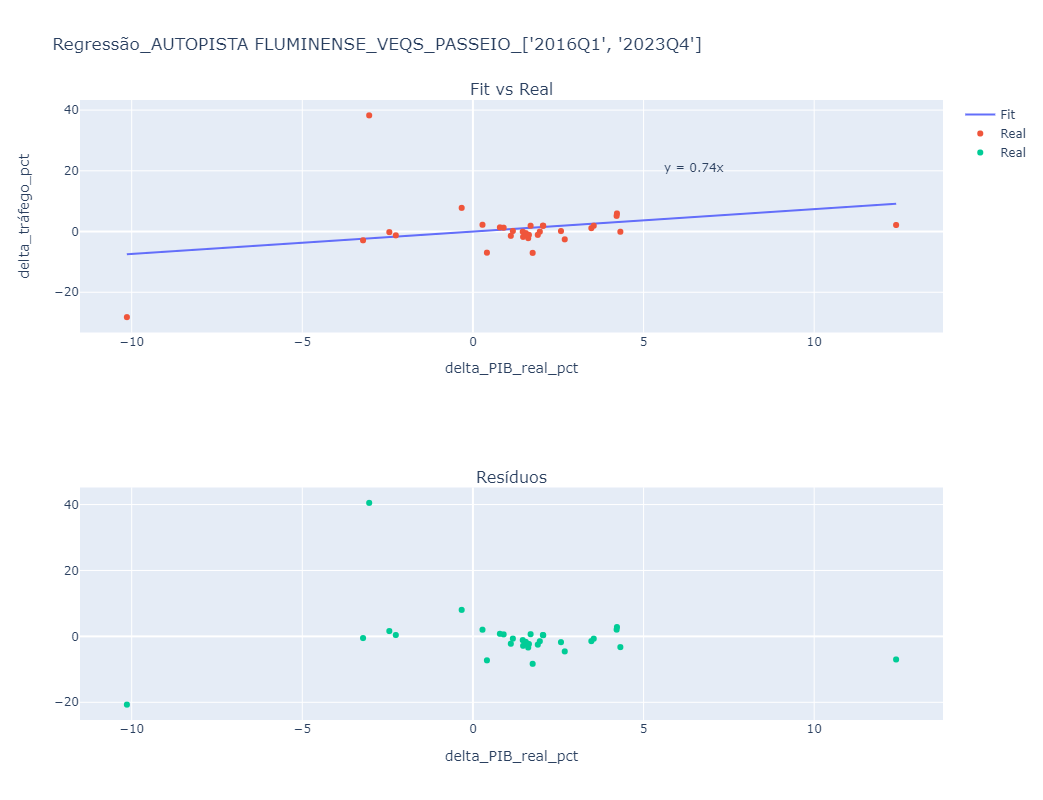

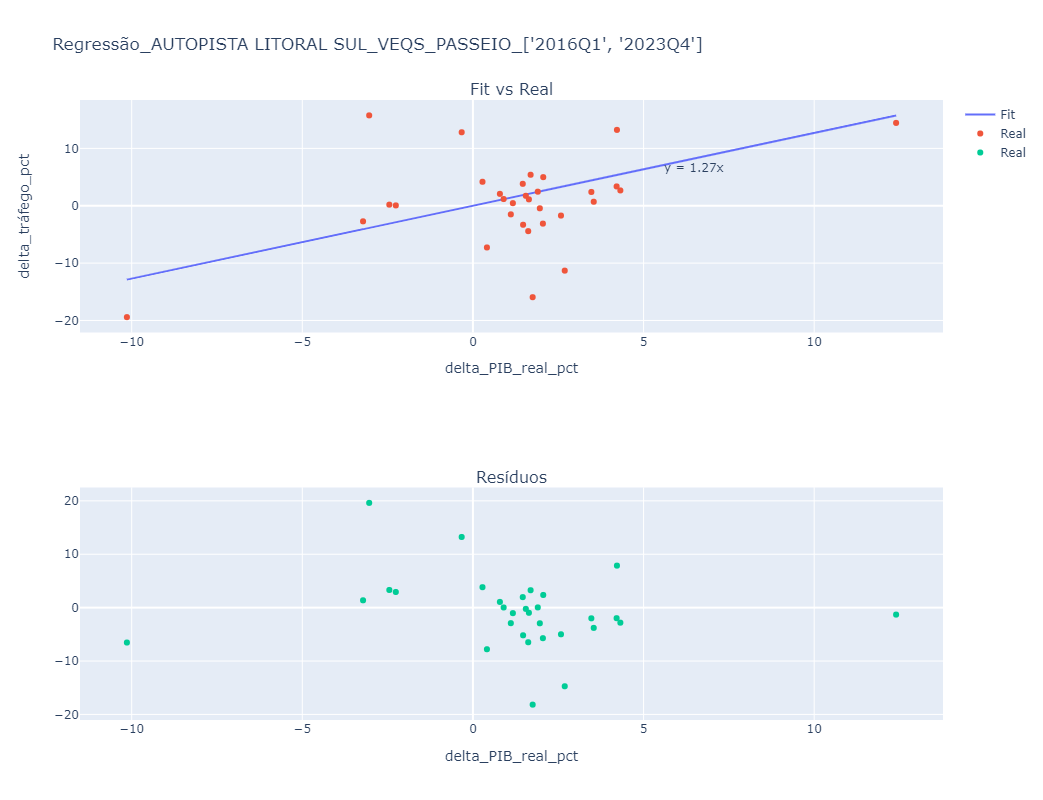

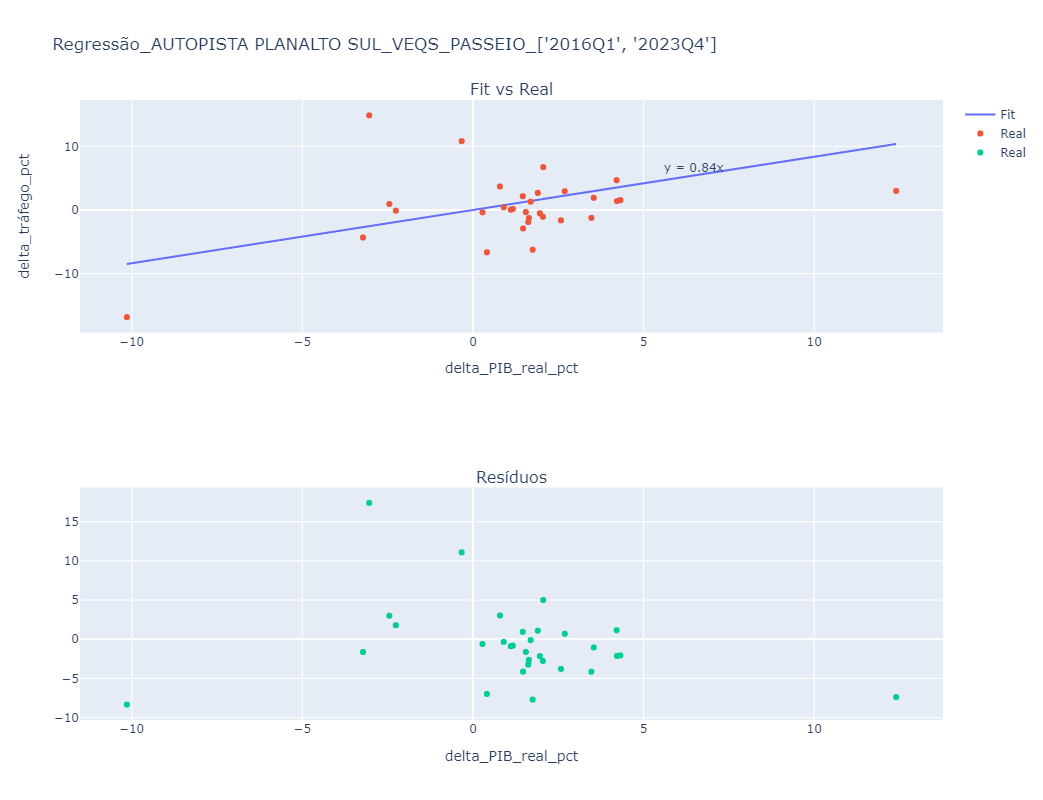

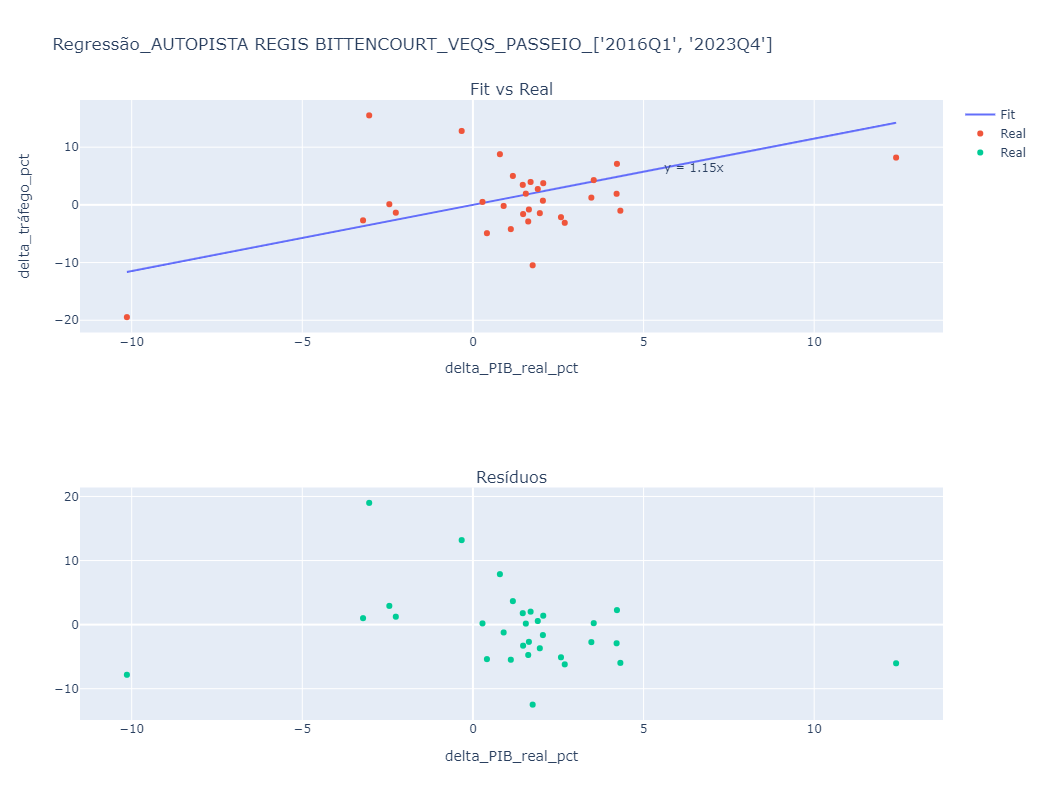

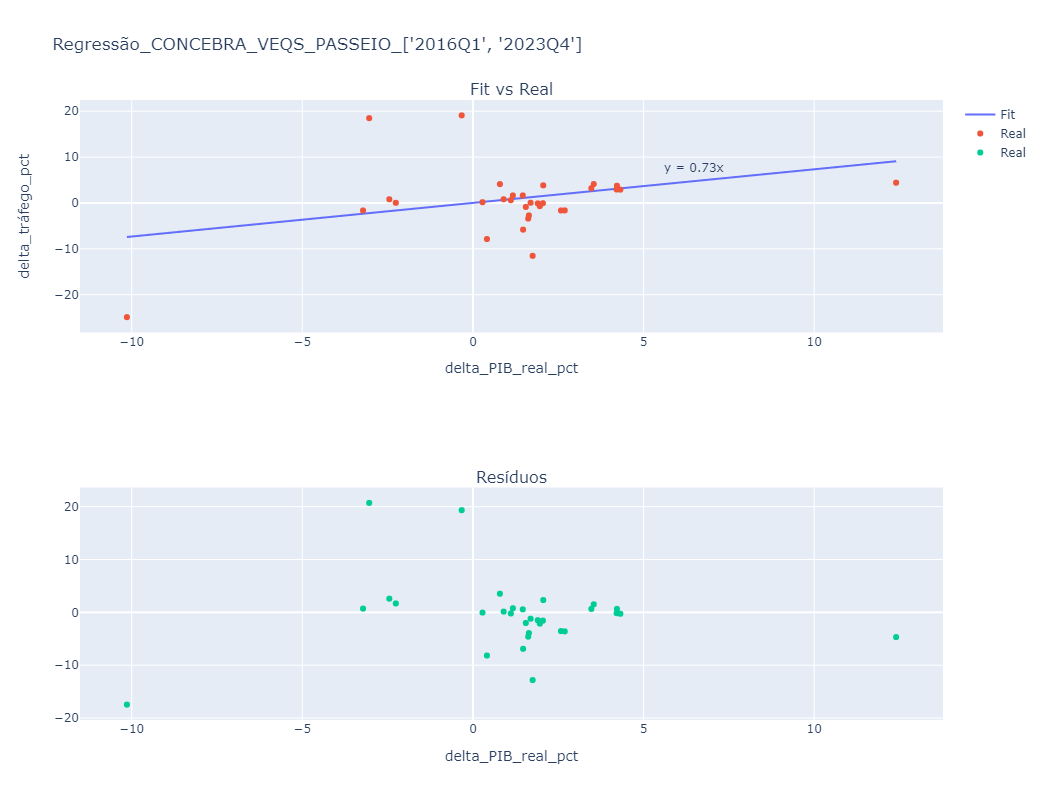

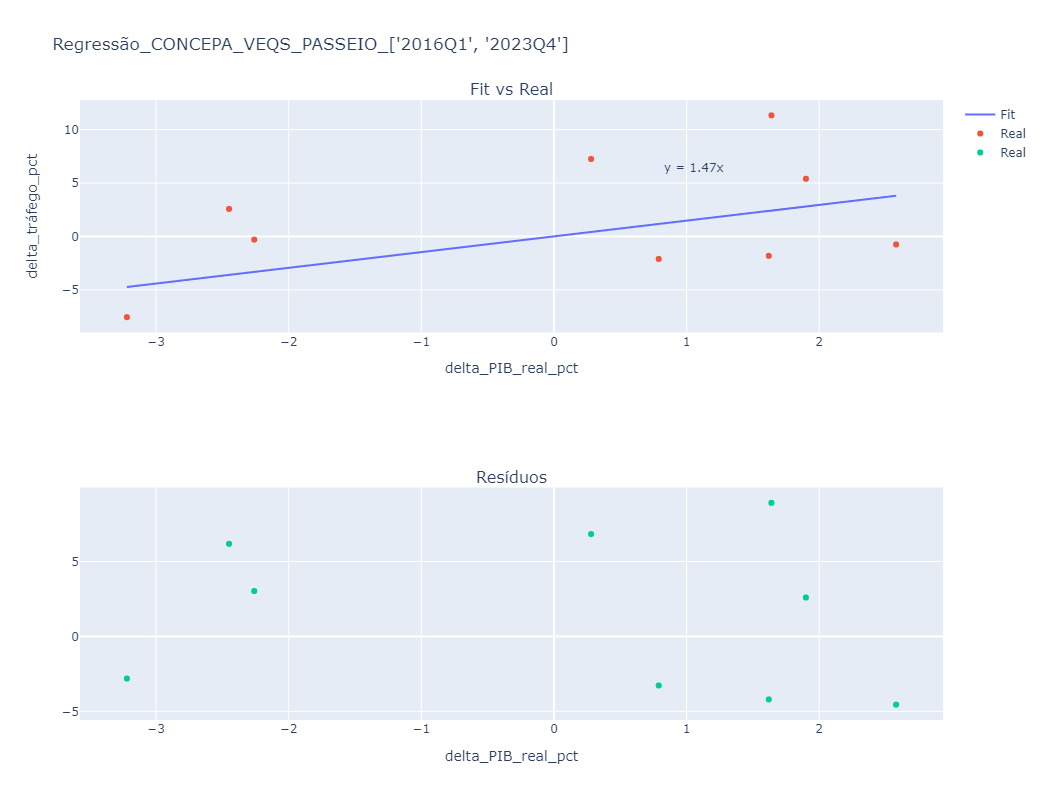

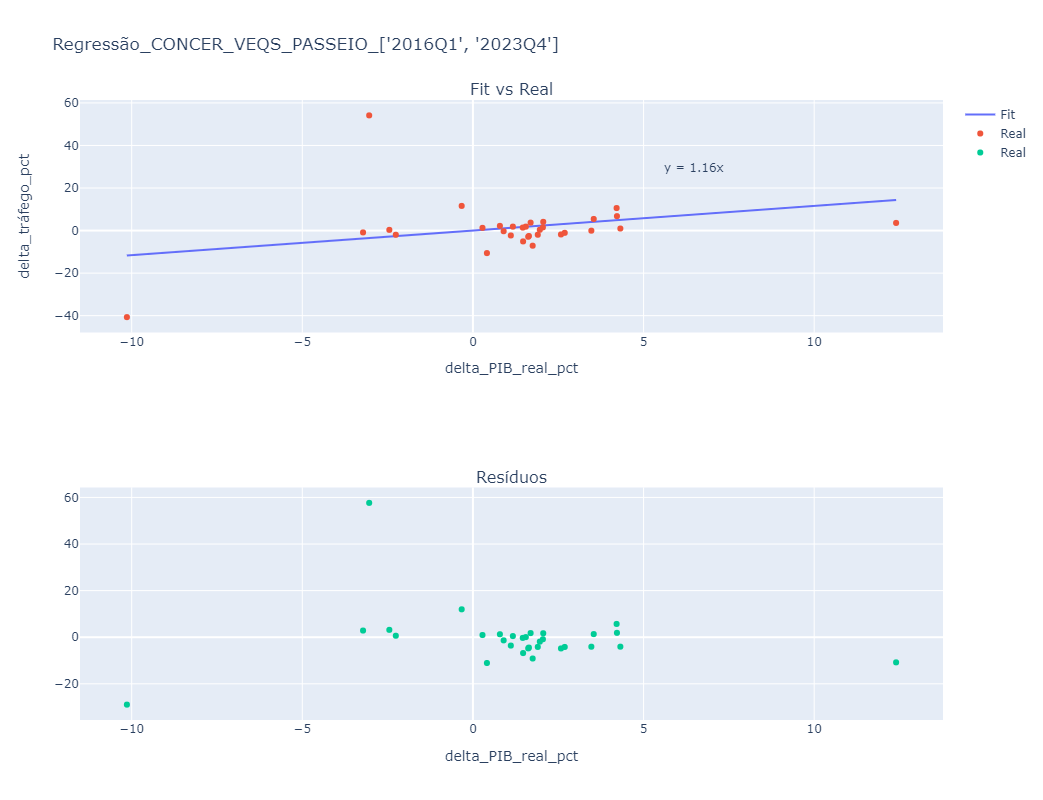

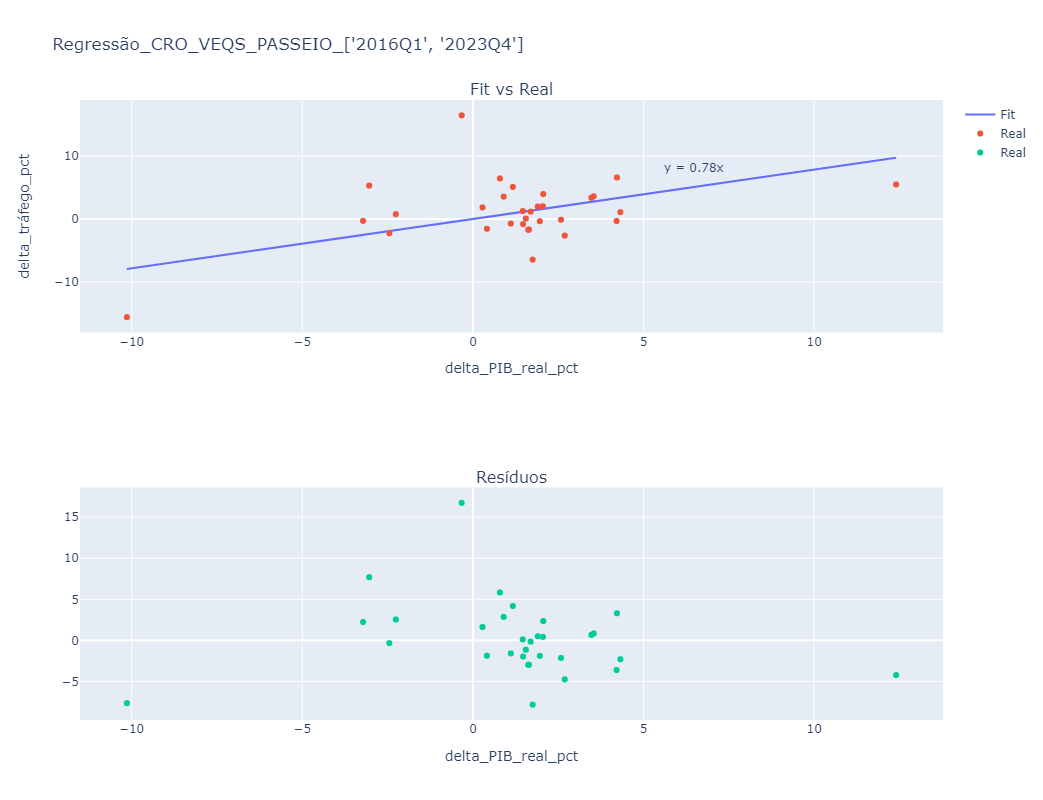

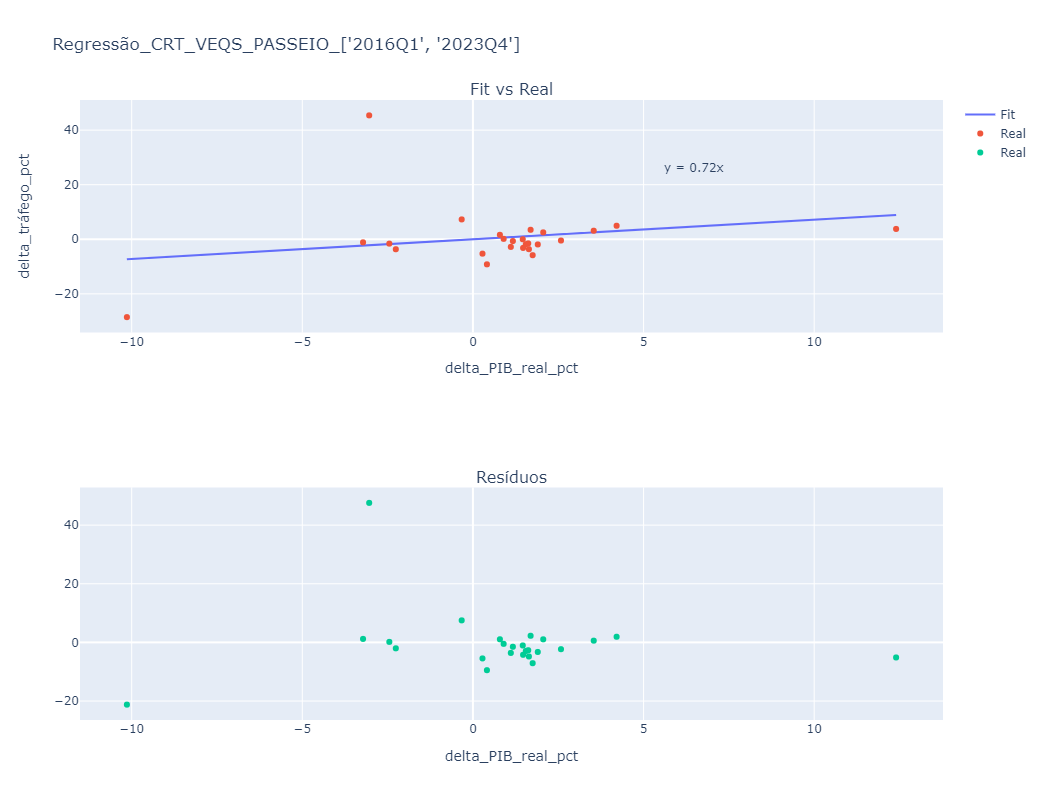

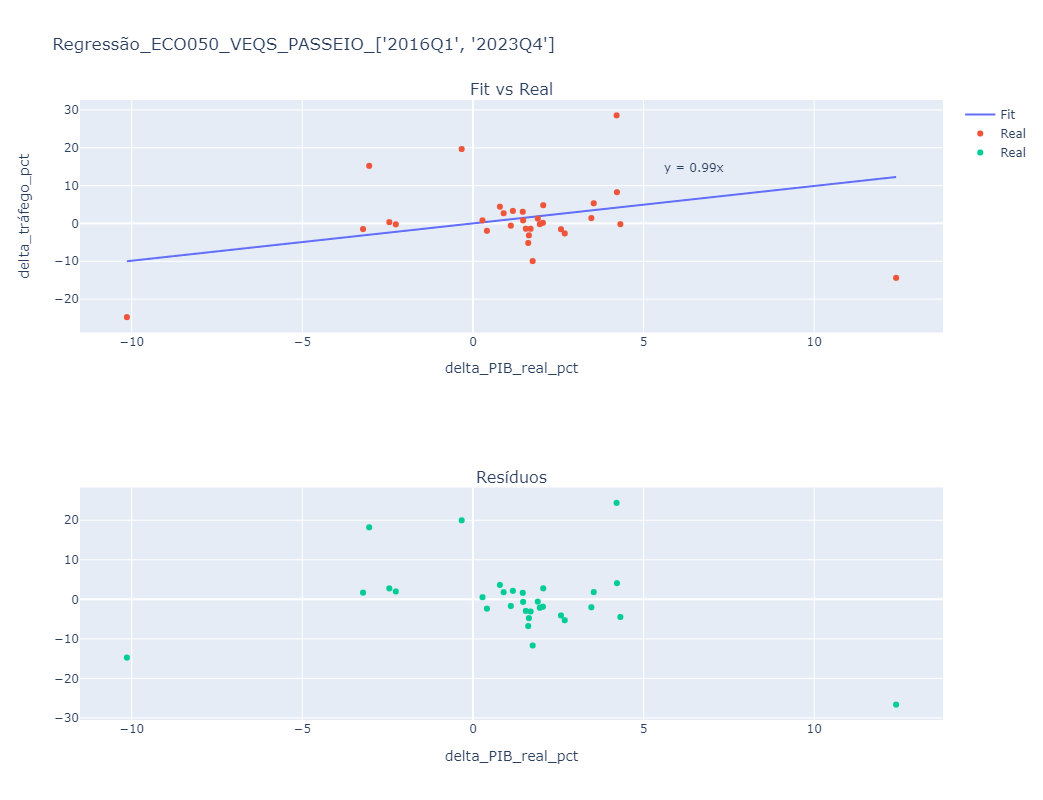

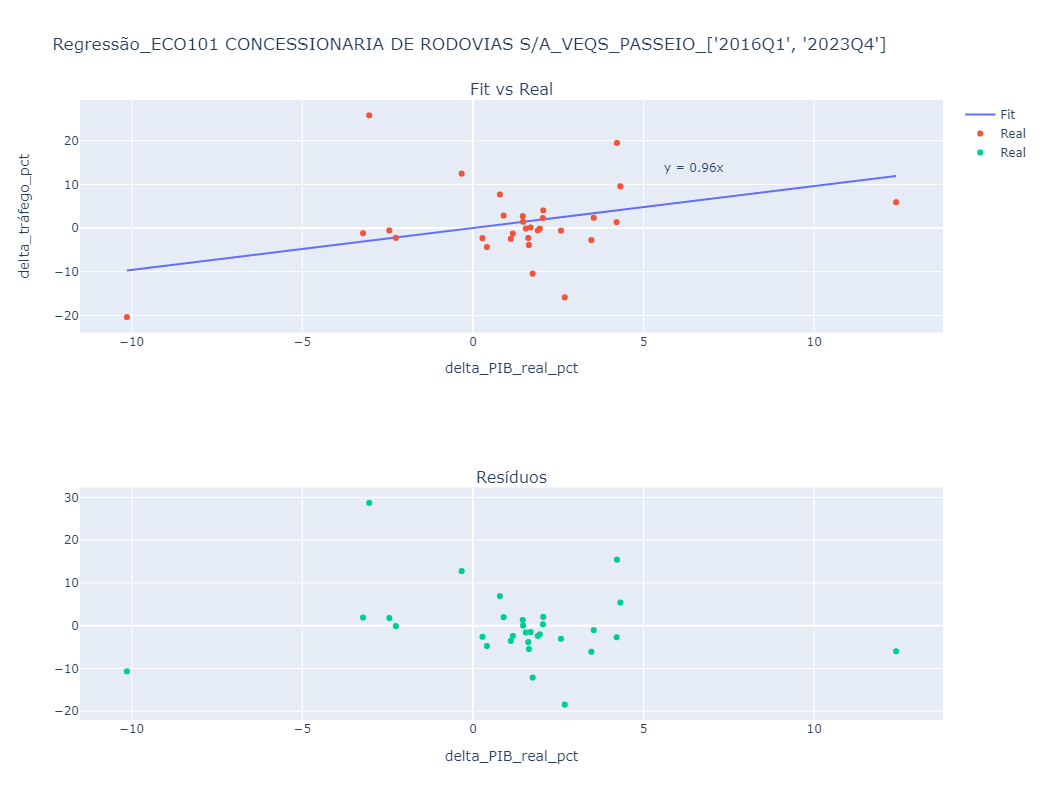

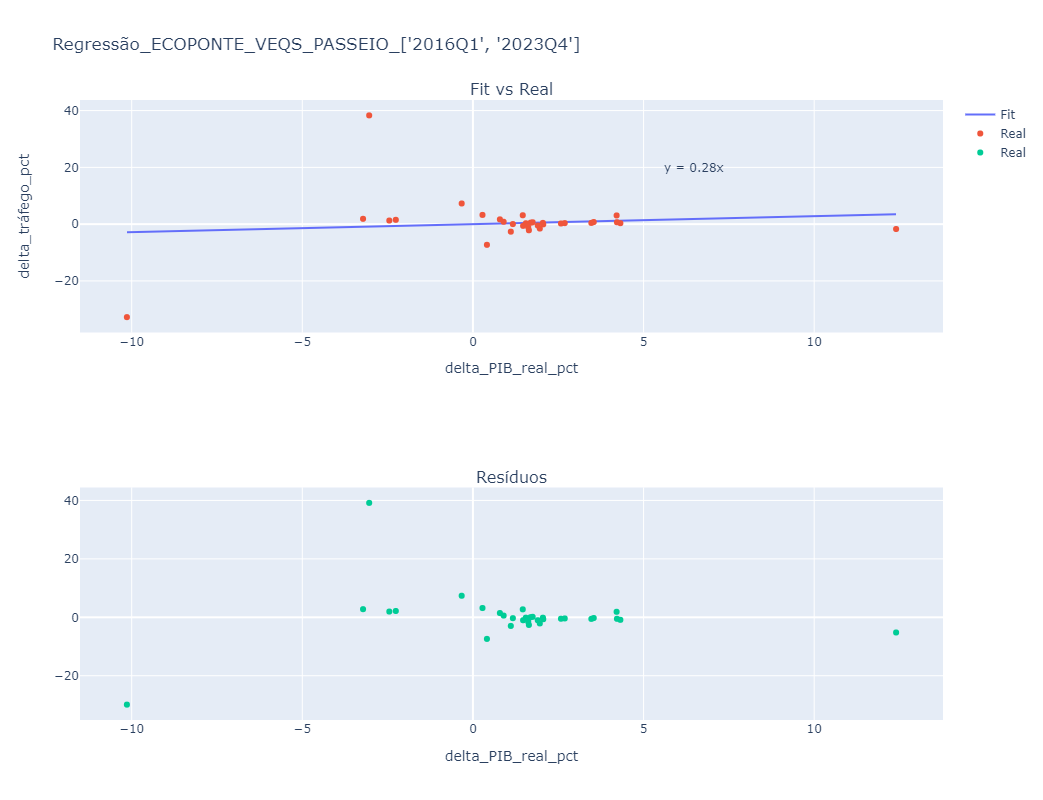

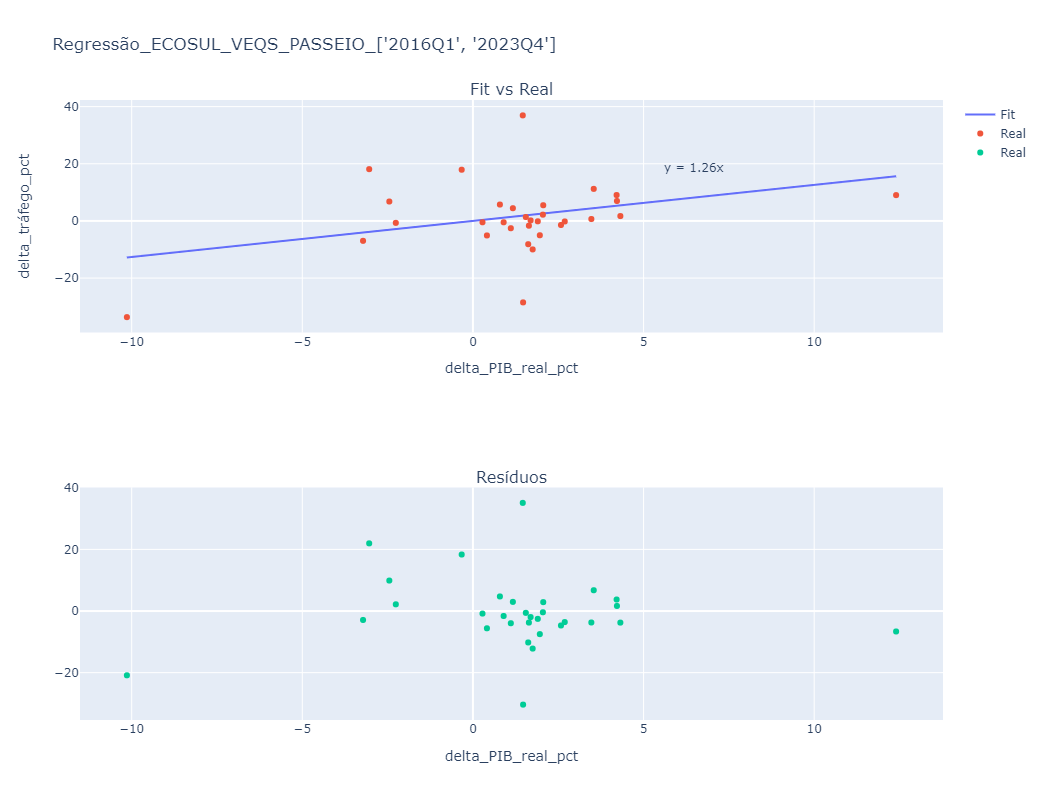

ECOVIAS DO CERRADO_VEQS_PASSEIO: dado não disponível


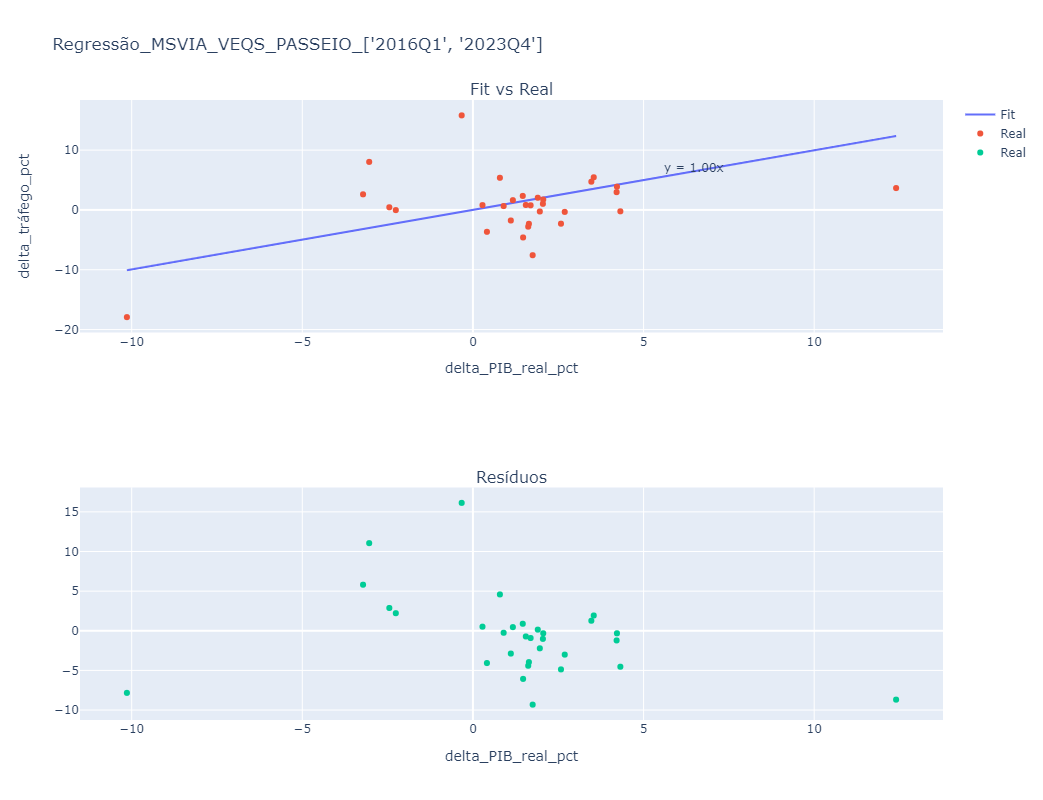

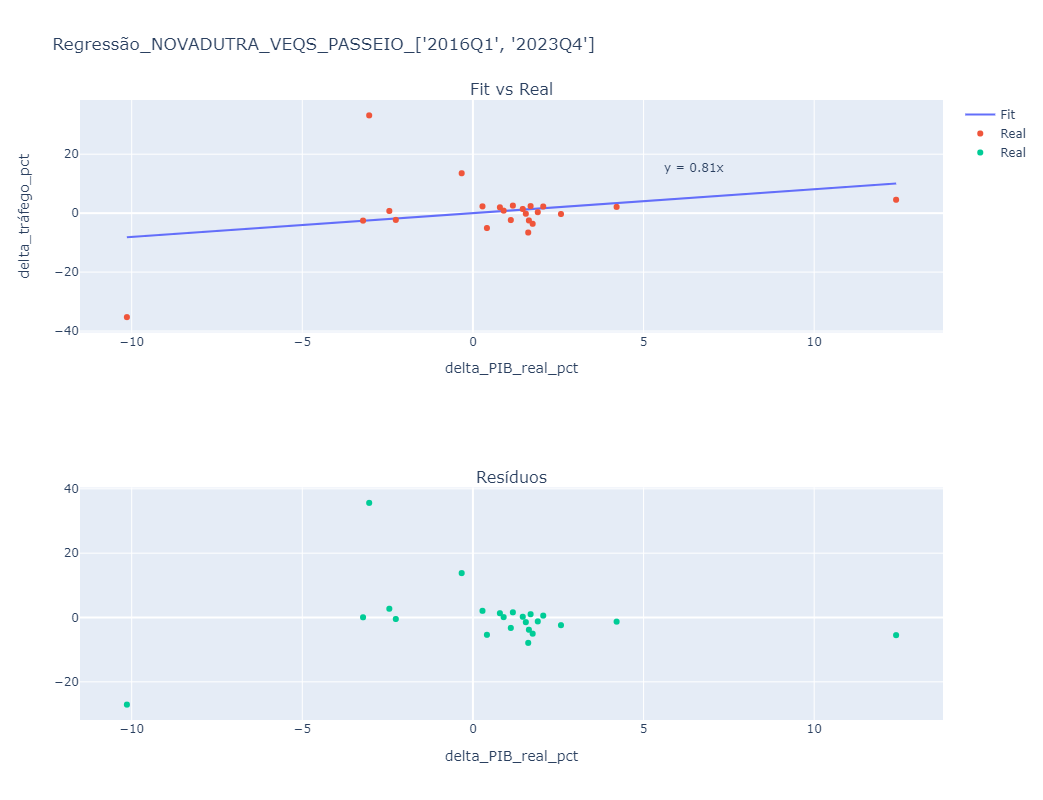

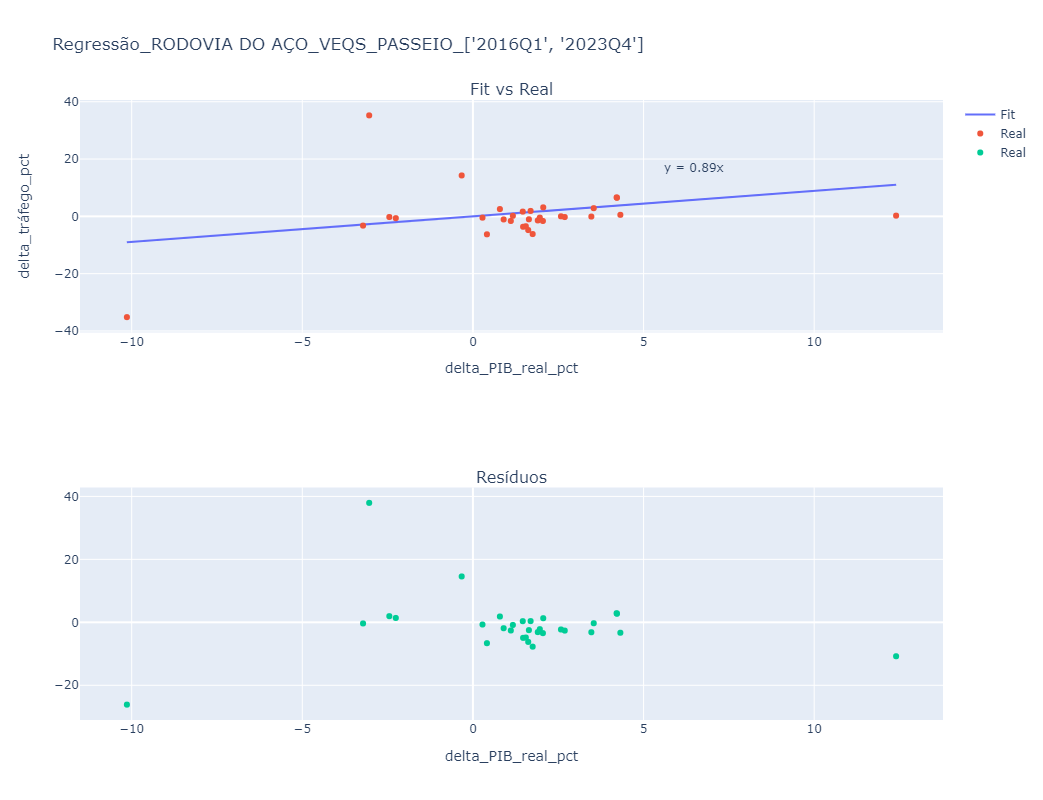

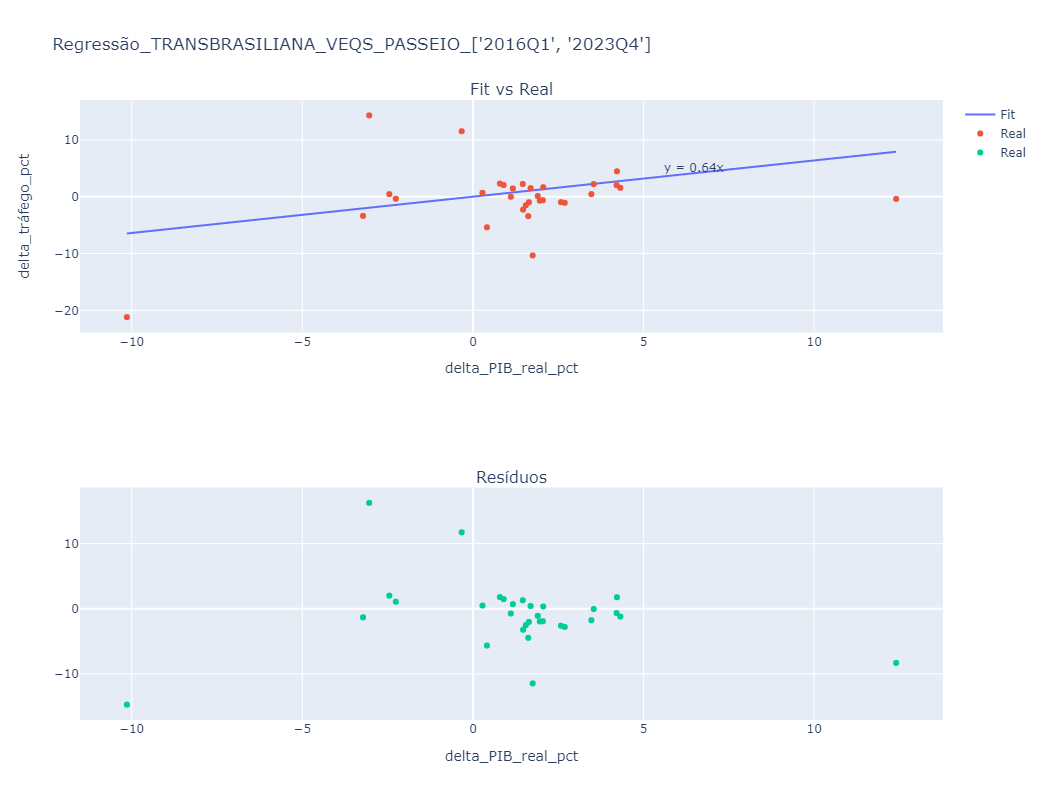

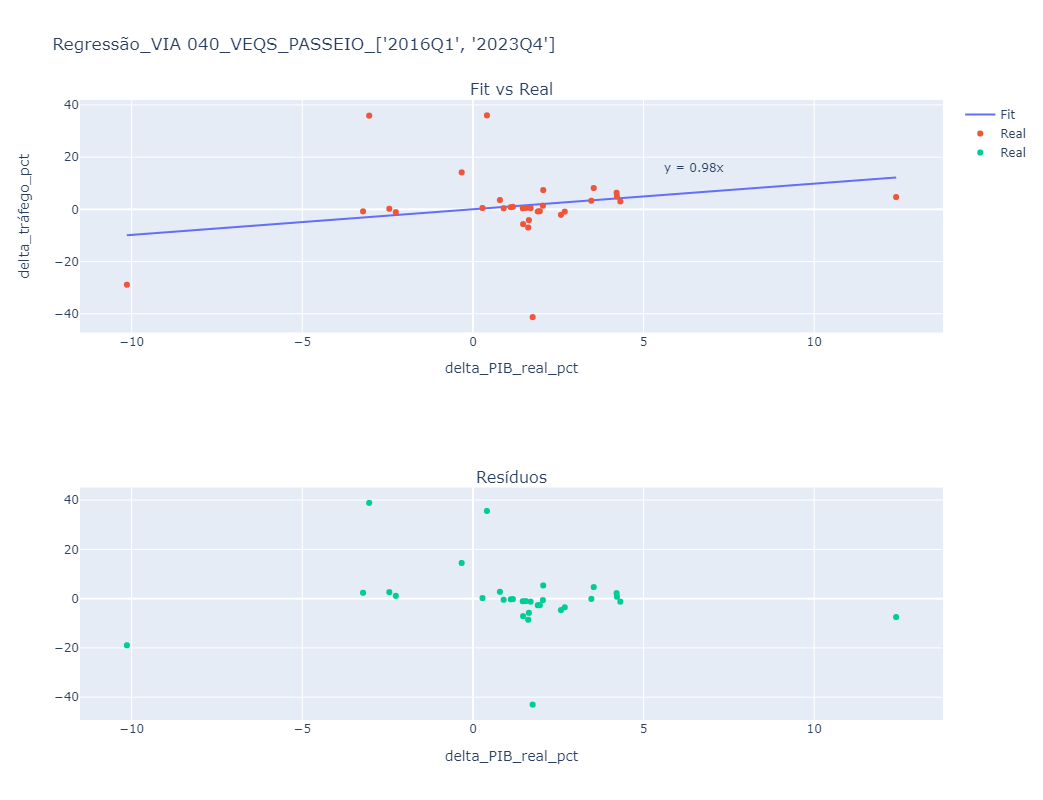

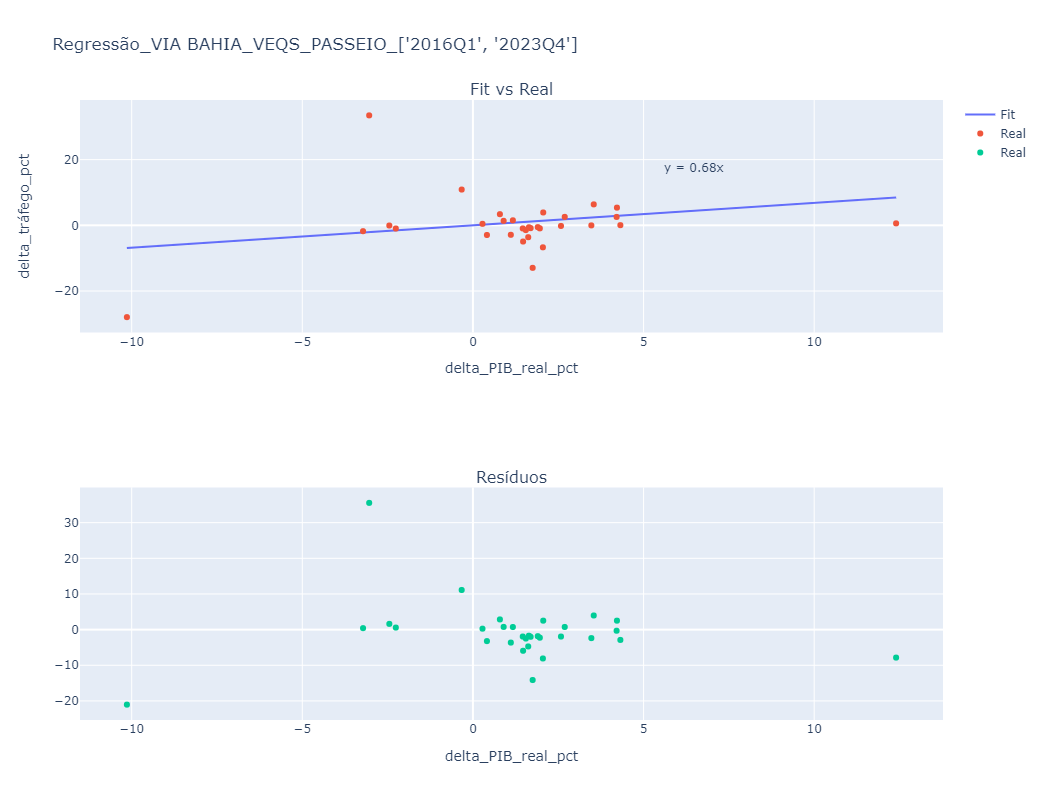

VIA SUL_VEQS_PASSEIO: dado não disponível


In [43]:
for veq, _dict in dict_curves_p2.items():
    for conc in _dict:
        fig = make_plot(_dict[conc], veq, conc, periodicidade, periodos[1])
        if fig is not None:
            fig.show()

# Salvando para excel

In [49]:
# Resultados consolidados por veq/periodo PERIODO 1
dict_resultados = dict_results_per1
periodo = periodos[0]
string_periodo = '_'.join(periodo)


with pd.ExcelWriter(path_outputs / f'resultado_regressoes_{string_periodo}_{periodicidade_path.lower()}.xlsx') as writer:
    for veq, df in dict_resultados.items():
        df_sheet = df
        max_string_size_sheet = 31
        sheet_name=f'{veq}'[:max_string_size_sheet]
        df_sheet.to_excel(writer, sheet_name=sheet_name)      

In [50]:
# Resultados consolidados por veq/periodo PERIODO 2
dict_resultados = dict_results_per2
periodo = periodos[1]

string_periodo = '_'.join(periodo)

with pd.ExcelWriter(path_outputs / f'resultado_regressoes_{string_periodo}_{periodicidade_path.lower()}.xlsx') as writer:
    for veq, df in dict_resultados.items():
        df_sheet = df
        max_string_size_sheet = 31
        sheet_name=f'{veq}'[:max_string_size_sheet]
        df_sheet.to_excel(writer, sheet_name=sheet_name)    

## Gráficos P/EXCEL

In [51]:
# PERIODO 1
periodo = periodos[0]
dict_curves = dict_curves_p1

string_periodo = '_'.join(periodo)

for veqs, _dict in dict_curves.items():
   
    wb = Workbook()
    wb.remove(wb.active)  # Remove the default sheet
    path_xlsx = path_outputs / f'graficos_regressao_{veqs}_{string_periodo}_{periodicidade_path.lower()}.xlsx'
    
    for conc, df_curves in _dict.items():
        if df_curves is not None:
            # print(type(df_curves),'tem df')
            path_temp = path_temp_figs / f"{veqs}_{string_periodo}_{conc[:31]}.png"
            figure = make_plot(df_curves, veqs, conc, periodicidade, periodo)
            write_image(figure, path_temp)
            ws = wb.create_sheet(title=conc[:31])
            img = Image(path_temp)
            ws.add_image(img,'A1') # A1 é a célula 
        else:
            print(conc,': NÃO DISPONÍVEL')
    wb.save(path_xlsx) # salvando o arquivo excel em disco

# Removendo os arquivos temporários
for veqs, _dict in dict_curves.items():
    for conc in _dict:
        try:
            path_remove = path_temp_figs / f"{veqs}_{string_periodo}_{conc[:31]}.png"
            os.remove(path_remove)
        except:
            print(path_remove)

CONCEBRA : NÃO DISPONÍVEL
CRO : NÃO DISPONÍVEL
ECO050 : NÃO DISPONÍVEL
ECO101 CONCESSIONARIA DE RODOVIAS S/A : NÃO DISPONÍVEL
ECOPONTE : NÃO DISPONÍVEL
ECOVIAS DO CERRADO : NÃO DISPONÍVEL
MSVIA : NÃO DISPONÍVEL
NOVADUTRA : NÃO DISPONÍVEL
VIA 040 : NÃO DISPONÍVEL
VIA BAHIA : NÃO DISPONÍVEL
VIA SUL : NÃO DISPONÍVEL
CONCEBRA : NÃO DISPONÍVEL
CRO : NÃO DISPONÍVEL
ECO050 : NÃO DISPONÍVEL
ECO101 CONCESSIONARIA DE RODOVIAS S/A : NÃO DISPONÍVEL
ECOPONTE : NÃO DISPONÍVEL
ECOVIAS DO CERRADO : NÃO DISPONÍVEL
MSVIA : NÃO DISPONÍVEL
NOVADUTRA : NÃO DISPONÍVEL
VIA 040 : NÃO DISPONÍVEL
VIA BAHIA : NÃO DISPONÍVEL
VIA SUL : NÃO DISPONÍVEL
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2010Q2_2023Q4_CONCEBRA.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2010Q2_2023Q4_CRO.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2010Q2_2023Q4_ECO050.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2010

In [52]:
# PERIODO 2
periodo = periodos[1]
dict_curves = dict_curves_p2

string_periodo = '_'.join(periodo)

for veqs, _dict in dict_curves.items():
   
    wb = Workbook()
    wb.remove(wb.active)  # Remove the default sheet
    path_xlsx = path_outputs / f'graficos_regressao_{veqs}_{string_periodo}_{periodicidade_path.lower()}.xlsx'
    
    for conc, df_curves in _dict.items():
        if df_curves is not None:
            # print(type(df_curves),'tem df')
            path_temp = path_temp_figs / f"{veqs}_{string_periodo}_{conc[:31]}.png"
            figure = make_plot(df_curves, veqs, conc, periodicidade, periodo)
            write_image(figure, path_temp)
            ws = wb.create_sheet(title=conc[:31])
            img = Image(path_temp)
            ws.add_image(img,'A1') # A1 é a célula 
        else:
            print(conc,': NÃO DISPONÍVEL')
    wb.save(path_xlsx) # salvando o arquivo excel em disco

# Removendo os arquivos temporários
for veqs, _dict in dict_curves.items():
    for conc in _dict:
        try:
            path_remove = path_temp_figs / f"{veqs}_{string_periodo}_{conc[:31]}.png"
            os.remove(path_remove)
        except:
            print(path_remove)

ECOVIAS DO CERRADO : NÃO DISPONÍVEL
VIA SUL : NÃO DISPONÍVEL
ECOVIAS DO CERRADO : NÃO DISPONÍVEL
VIA SUL : NÃO DISPONÍVEL
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2016Q1_2023Q4_ECOVIAS DO CERRADO.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_COMERCIAL_2016Q1_2023Q4_VIA SUL.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_PASSEIO_2016Q1_2023Q4_ECOVIAS DO CERRADO.png
/home/andcm/work/Projetos/infra-data/dados/derivados/temp/VEQS_PASSEIO_2016Q1_2023Q4_VIA SUL.png
